In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.lines import Line2D   

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.utils import resample
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.mixture import GaussianMixture
import time

In [2]:
spotify_df = pd.read_csv('data\SpotifyFeatures.csv')

In [3]:
print(spotify_df.shape)
print(spotify_df.columns.tolist())

(232725, 18)
['genre', 'artist_name', 'track_name', 'track_id', 'popularity', 'acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'time_signature', 'valence']


In [4]:
spotify_df.head()

genre        artist_name                        track_name  \
0  Movie     Henri Salvador       C'est beau de faire un Show   
1  Movie  Martin & les fées  Perdu d'avance (par Gad Elmaleh)   
2  Movie    Joseph Williams    Don't Let Me Be Lonely Tonight   
3  Movie     Henri Salvador    Dis-moi Monsieur Gordon Cooper   
4  Movie       Fabien Nataf                         Ouverture   

                 track_id  popularity  acousticness  danceability  \
0  0BRjO6ga9RKCKjfDqeFgWV           0         0.611         0.389   
1  0BjC1NfoEOOusryehmNudP           1         0.246         0.590   
2  0CoSDzoNIKCRs124s9uTVy           3         0.952         0.663   
3  0Gc6TVm52BwZD07Ki6tIvf           0         0.703         0.240   
4  0IuslXpMROHdEPvSl1fTQK           4         0.950         0.331   

   duration_ms  energy  instrumentalness key  liveness  loudness   mode  \
0        99373   0.910             0.000  C#    0.3460    -1.828  Major   
1       137373   0.737             0.000  F#    0.1510    -5.559  Minor   
2       170267   0.131             0.000   C    0.1030   -13.879  Minor   
3       152427   0.326             0.000  C#    0.0985   -12.178  Major   
4        82625   0.225             0.123   F    0.2020   -21.150  Major   

   speechiness    tempo time_signature  valence  
0       0.0525  166.969            4/4    0.814  
1       0.0868  174.003            4/4    0.816  
2       0.0362   99.488            5/4    0.368  
3       0.0395  171.758            4/4    0.227  
4       0.0456  140.576            4/4    0.390

In [5]:
spotify_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232725 entries, 0 to 232724
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   genre             232725 non-null  object 
 1   artist_name       232725 non-null  object 
 2   track_name        232725 non-null  object 
 3   track_id          232725 non-null  object 
 4   popularity        232725 non-null  int64  
 5   acousticness      232725 non-null  float64
 6   danceability      232725 non-null  float64
 7   duration_ms       232725 non-null  int64  
 8   energy            232725 non-null  float64
 9   instrumentalness  232725 non-null  float64
 10  key               232725 non-null  object 
 11  liveness          232725 non-null  float64
 12  loudness          232725 non-null  float64
 13  mode              232725 non-null  object 
 14  speechiness       232725 non-null  float64
 15  tempo             232725 non-null  float64
 16  time_signature    23

In [6]:
spotify_df.describe()

popularity   acousticness   danceability   duration_ms  \
count  232725.000000  232725.000000  232725.000000  2.327250e+05   
mean       41.127502       0.368560       0.554364  2.351223e+05   
std        18.189948       0.354768       0.185608  1.189359e+05   
min         0.000000       0.000000       0.056900  1.538700e+04   
25%        29.000000       0.037600       0.435000  1.828570e+05   
50%        43.000000       0.232000       0.571000  2.204270e+05   
75%        55.000000       0.722000       0.692000  2.657680e+05   
max       100.000000       0.996000       0.989000  5.552917e+06   

              energy  instrumentalness       liveness       loudness  \
count  232725.000000     232725.000000  232725.000000  232725.000000   
mean        0.570958          0.148301       0.215009      -9.569885   
std         0.263456          0.302768       0.198273       5.998204   
min         0.000020          0.000000       0.009670     -52.457000   
25%         0.385000          0.000000       0.097400     -11.771000   
50%         0.605000          0.000044       0.128000      -7.762000   
75%         0.787000          0.035800       0.264000      -5.501000   
max         0.999000          0.999000       1.000000       3.744000   

         speechiness          tempo        valence  
count  232725.000000  232725.000000  232725.000000  
mean        0.120765     117.666585       0.454917  
std         0.185518      30.898907       0.260065  
min         0.022200      30.379000       0.000000  
25%         0.036700      92.959000       0.237000  
50%         0.050100     115.778000       0.444000  
75%         0.105000     139.054000       0.660000  
max         0.967000     242.903000       1.000000

In [7]:
# Check for duplicates
duplicates = spotify_df.duplicated()
num_duplicates = duplicates.sum()

print(f"\nNumber of duplicate rows: {num_duplicates}")
if num_duplicates > 0:
    print("\nExample duplicates:")
    display(spotify_df[duplicates].head())


Number of duplicate rows: 0


In [8]:
numeric_feats = ['popularity','acousticness','danceability',
                 'energy','instrumentalness','liveness',
                 'loudness','speechiness','tempo','valence']

df = spotify_df[numeric_feats].copy()

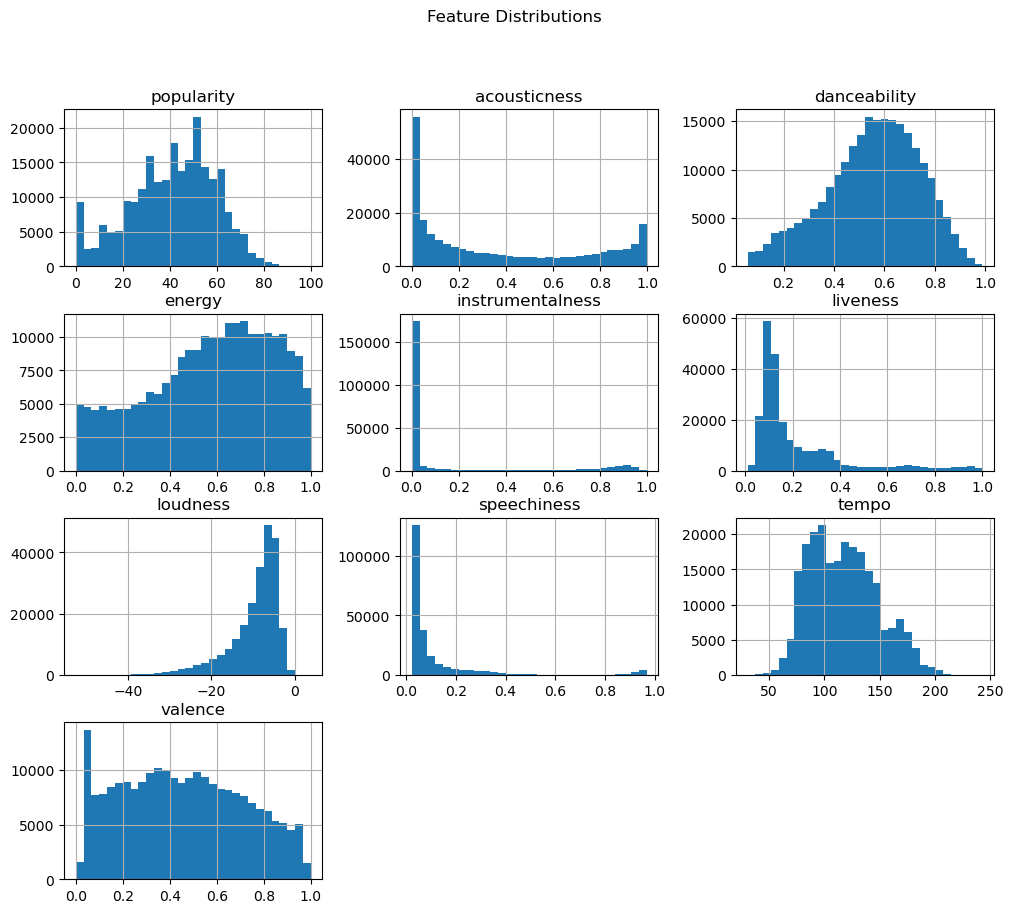

In [9]:
# Histograms
df.hist(bins=30, figsize=(12,10))
plt.suptitle('Feature Distributions')
plt.show()

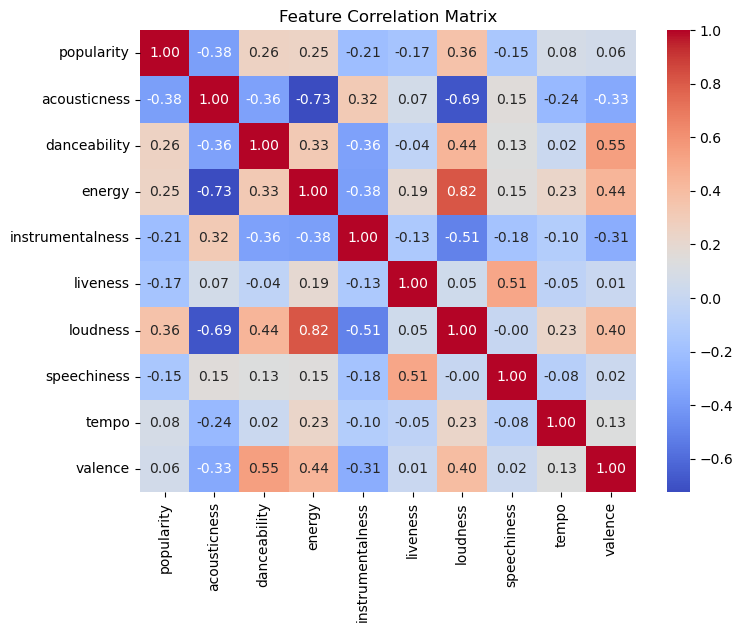

In [10]:
# Correlation heatmap
plt.figure(figsize=(8,6))
sns.heatmap(df[numeric_feats].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

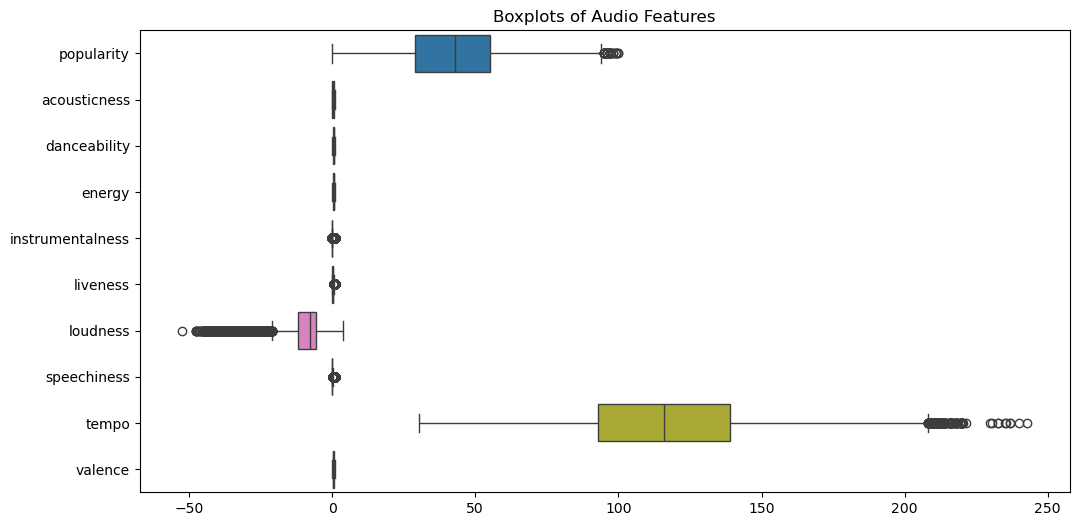

In [11]:
# Boxplots 
plt.figure(figsize=(12,6))
sns.boxplot(data=df, orient='h')
plt.title('Boxplots of Audio Features')
plt.show()

In [12]:
# Find the Outlier using IQR 
outlier_counts = {}

for col in numeric_feats:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower) | (df[col] > upper)]
    outlier_counts[col] = outliers.shape[0]

for col, count in sorted(outlier_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"{col}: {count}")

instrumentalness: 51545
speechiness: 32979
liveness: 21241
loudness: 14171
tempo: 168
popularity: 38
acousticness: 0
danceability: 0
energy: 0
valence: 0


In [13]:
# remove outliers
df_clean = df.copy()

for col in numeric_feats:
    Q1 = df_clean[col].quantile(0.25)
    Q3 = df_clean[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    # Keep only rows where the value is within bounds
    df_clean = df_clean[(df_clean[col] >= lower) & (df_clean[col] <= upper)]

print(f"Original shape: {df.shape}")
print(f"Cleaned shape: {df_clean.shape}")

Original shape: (232725, 10)
Cleaned shape: (137411, 10)


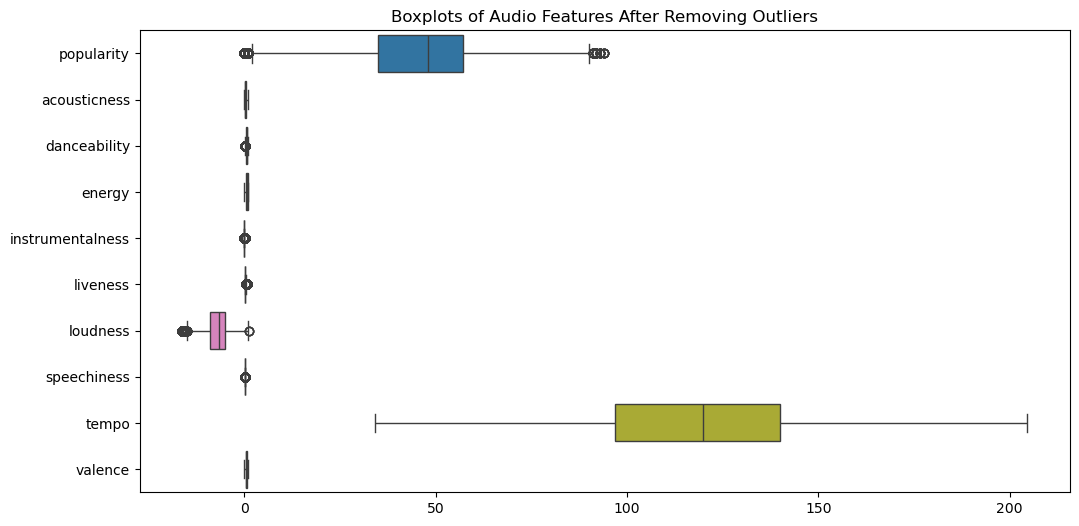

In [14]:
# Boxplots 
plt.figure(figsize=(12,6))
sns.boxplot(data=df_clean, orient='h')
plt.title('Boxplots of Audio Features After Removing Outliers')
plt.show()

In [15]:
# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)
X_scaled_clean = scaler.fit_transform(df_clean)

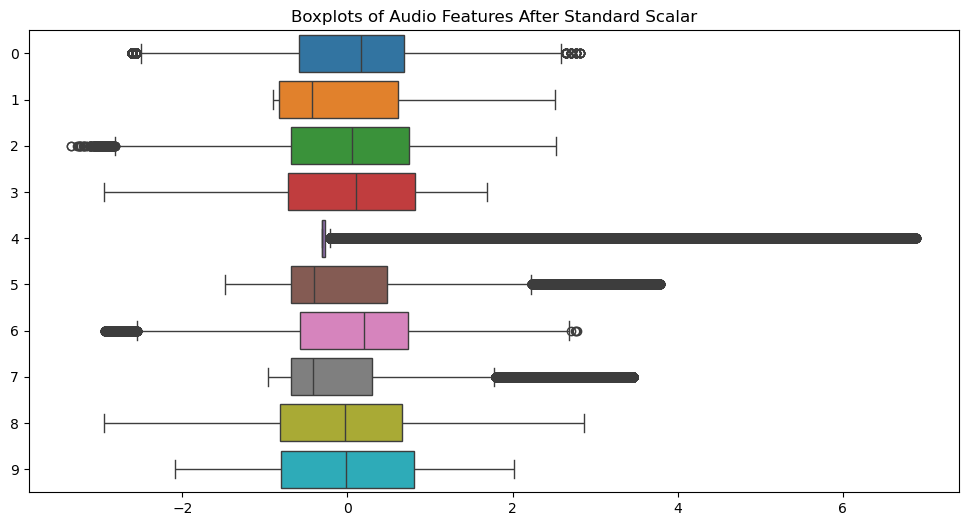

In [16]:
# Boxplots 
plt.figure(figsize=(12,6))
sns.boxplot(data=X_scaled_clean, orient='h')
plt.title('Boxplots of Audio Features After Standard Scalar')
plt.show()

### Find Optimal K

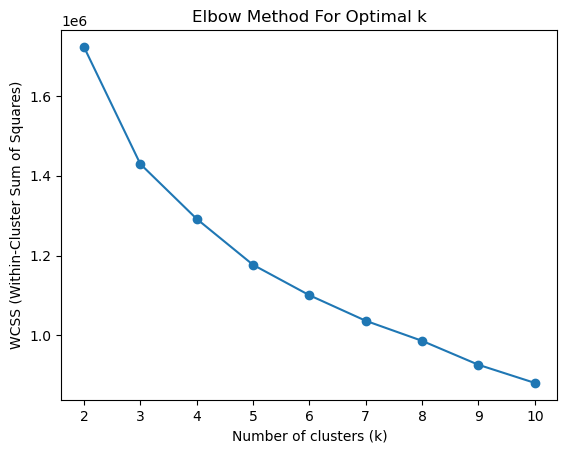

In [22]:
wcss = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(range(2, 11), wcss, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.title('Elbow Method For Optimal k')
plt.show()

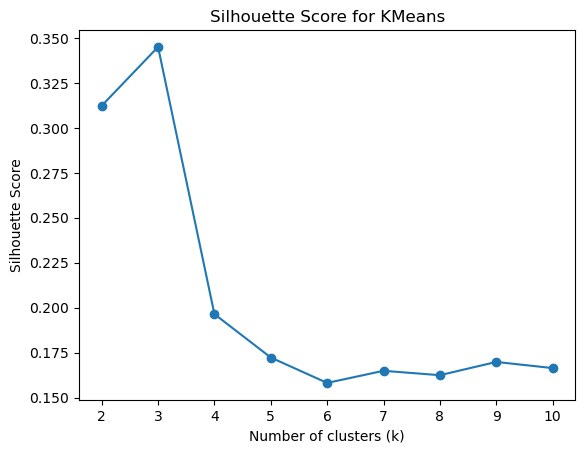

In [23]:
# Resample to smaller number of data
# X_sample = resample(X_scaled, n_samples=50000, random_state=42)
sil_scores = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    sil_scores.append(score)

plt.plot(range(2, 11), sil_scores, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for KMeans')
plt.show()

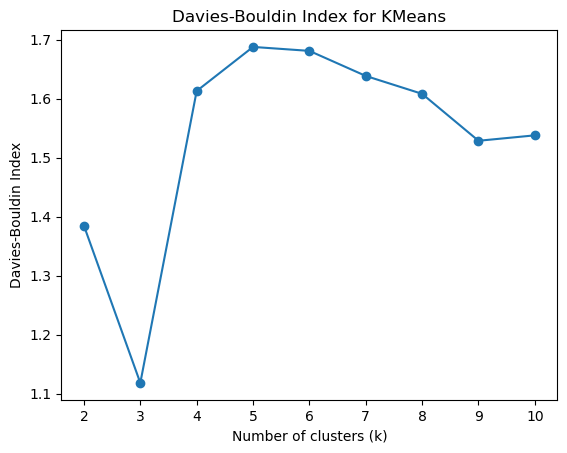

In [24]:
dbi_scores = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = kmeans.fit_predict(X_scaled)
    dbi = davies_bouldin_score(X_scaled, labels)
    dbi_scores.append(dbi)

plt.plot(range(2, 11), dbi_scores, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Davies-Bouldin Index')
plt.title('Davies-Bouldin Index for KMeans')
plt.show()

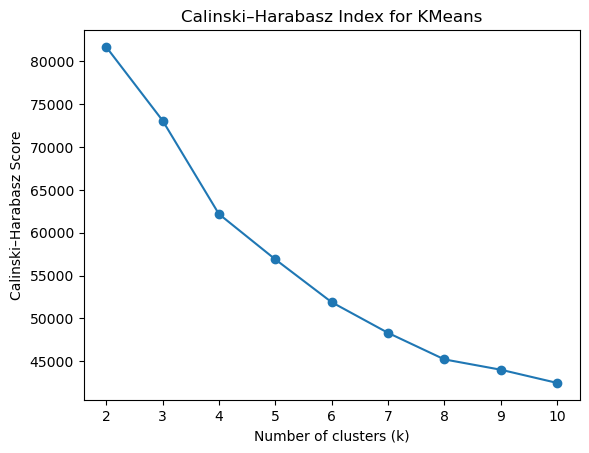

In [25]:
ch_scores = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = kmeans.fit_predict(X_scaled)
    score = calinski_harabasz_score(X_scaled, labels)
    ch_scores.append(score)

plt.plot(range(2, 11), ch_scores, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Calinski–Harabasz Score')
plt.title('Calinski–Harabasz Index for KMeans')
plt.show()


#### Gap Statistics

In [26]:
def compute_Wk(data, n_clusters):
    # run Kmeans and return WCSS (inertia)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
    kmeans.fit(data)
    return kmeans.inertia_

def gap_statistic(X, max_k=10, B=10):
    # Compute Gap Statistic for range of k from 1 to max_k.
    # B: num of reference dataset
    shape = X.shape
    mins = np.min(X, axis=0)
    maxs = np.max(X, axis=0)
    
    # Stores the log(WCSS) 
    Wks = []
    # Stores the log(WCSS) for the reference dataset 
    Wkbs = np.zeros((max_k, B))

    # Compute WCSS for the actual data
    for k in range(1, max_k + 1):
        Wk = compute_Wk(X, k)
        Wks.append(np.log(Wk))

        # Generate refrence data and compute the WCSS
        for b in range(B):
            Xb = np.random.uniform(mins, maxs, size=shape)
            Wkb = compute_Wk(Xb, k)
            Wkbs[k - 1, b] = np.log(Wkb)

    # gaps: list of Gap(k) values
    gaps = np.mean(Wkbs, axis=1) - Wks
    # sk: standard deviation of reference Wk values
    sk = np.std(Wkbs, axis=1) * np.sqrt(1 + 1 / B)

    return gaps, sk

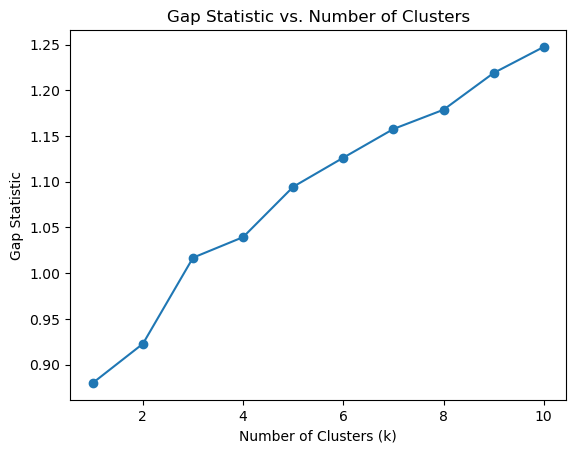

In [27]:
gaps, sk = gap_statistic(X_scaled, max_k=10, B=20)

plt.plot(range(1, len(gaps)+1), gaps, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Gap Statistic")
plt.title("Gap Statistic vs. Number of Clusters")
plt.show()

In [28]:
def compute_gap_statistic(X, k, n_refs=5):
    # Take X (datapoints) as input
    # k: num of clusters to evaluate
    # n_refs: also as b is the reference datasates to generate
    # runs kmeans and calculate the dispersion
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto').fit(X)
    # pairwise_distances gives the distance between each point to own cluster
    orig_disp = np.mean(np.min(pairwise_distances(X, kmeans.cluster_centers_), axis=1))

    # Create reference dataset
    ref_disps = []
    for _ in range(n_refs):
        # Create reference dataset with uniformly distributed random points
        random_ref = np.random.uniform(X.min(axis=0), X.max(axis=0), size=X.shape)
        # compute kmeans and cal dispersion on the reference data
        kmeans_ref = KMeans(n_clusters=k, random_state=42, n_init='auto').fit(random_ref)
        ref_disp = np.mean(np.min(pairwise_distances(random_ref, kmeans_ref.cluster_centers_), axis=1))
        ref_disps.append(ref_disp)

    # takes the log of the average dispersion from the random data
    # subtracts the log of the dispersion on real data
    log_ref = np.log(ref_disps)
    gap = np.mean(log_ref) - np.log(orig_disp)
    err = np.std(log_ref) * np.sqrt(1 + 1/n_refs)
    return gap, err

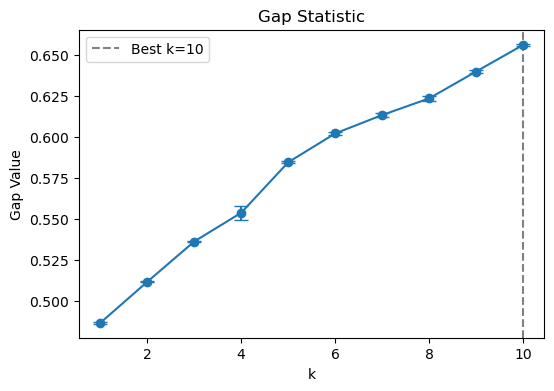

In [29]:
gap_scores = []
gap_errors = []
K = range(1, 11)

for k in K:
    gap, err = compute_gap_statistic(X_scaled, k=k, n_refs=20)
    gap_scores.append(gap)
    gap_errors.append(err)
    
best_gap_k = None
for i in range(len(K) - 1):
    if gap_scores[i] >= gap_scores[i + 1] - gap_errors[i + 1]:
        best_gap_k = K[i]
        break

if best_gap_k is None:
    best_gap_k = K[np.argmax(gap_scores)]
    
plt.figure(figsize=(6, 4))
plt.errorbar(K, gap_scores, yerr=gap_errors, marker='o', capsize=5)
plt.axvline(x=best_gap_k, linestyle='--', color='gray', label=f"Best k={best_gap_k}")
plt.title("Gap Statistic")
plt.xlabel("k")
plt.ylabel("Gap Value")
plt.legend()
plt.show()

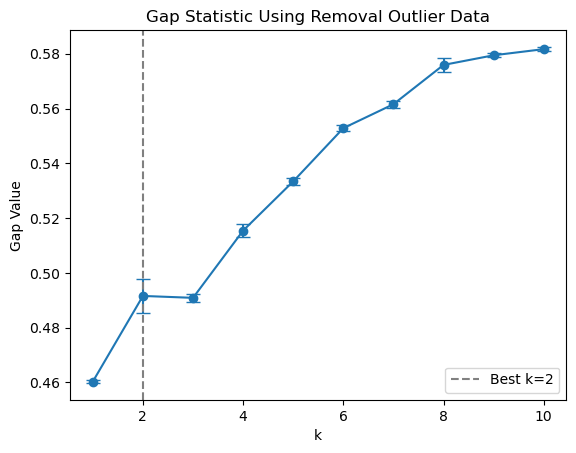

In [19]:
gap_scores = []
gap_errors = []
K = range(1, 11)

for k in K:
    gap, err = compute_gap_statistic(X_scaled_clean, k=k, n_refs=20)
    gap_scores.append(gap)
    gap_errors.append(err)

best_gap_k = None
for i in range(len(K) - 1):
    if gap_scores[i] >= gap_scores[i + 1] - gap_errors[i + 1]:
        best_gap_k = K[i]
        break

if best_gap_k is None:
    best_gap_k = K[np.argmax(gap_scores)]
    
plt.errorbar(K, gap_scores, yerr=gap_errors, marker='o', capsize=5)
plt.axvline(x=best_gap_k, linestyle='--', color='gray', label=f"Best k={best_gap_k}")
plt.title("Gap Statistic Using Removal Outlier Data")
plt.xlabel("k")
plt.ylabel("Gap Value")
plt.legend()
plt.show()

In [30]:
def gap_statistic(X, max_k=10, B=10, random_state=42, verbose=True):
    rng = np.random.default_rng(random_state)
    n, d = X.shape
    mins, maxs = X.min(axis=0), X.max(axis=0)

    logW = np.zeros(max_k)
    logW_ref = np.zeros((max_k, B))

    # Helper to compute inertia (within-cluster sum of squares)
    def compute_wk(data, k):
        return KMeans(n_clusters=k, random_state=random_state, n_init='auto').fit(data).inertia_

    for k in range(1, max_k + 1):
        logW[k - 1] = np.log(compute_wk(X, k))
        for b in range(B):
            Xb = rng.uniform(mins, maxs, size=(n, d))
            logW_ref[k - 1, b] = np.log(compute_wk(Xb, k))

    gaps = logW_ref.mean(axis=1) - logW
    sk = logW_ref.std(axis=1, ddof=1) * np.sqrt(1 + 1 / B)

    # Tibshirani rule: smallest k s.t. Gap(k) >= Gap(k+1) - s_{k+1}
    best_k = None
    for i in range(max_k - 1):
        if gaps[i] >= gaps[i + 1] - sk[i + 1]:
            best_k = i + 1
            break
    if best_k is None:
        best_k = max_k

    if verbose:
        print(f"{'k':>2}  {'Gap':>8}  {'s_k':>8}")
        for i in range(max_k):
            print(f"{i+1:>2}  {gaps[i]:8.3f}  {sk[i]:8.3f}")
        print(f"\nOptimal k according to Gap Statistic: {best_k}")

    return best_k, gaps, sk


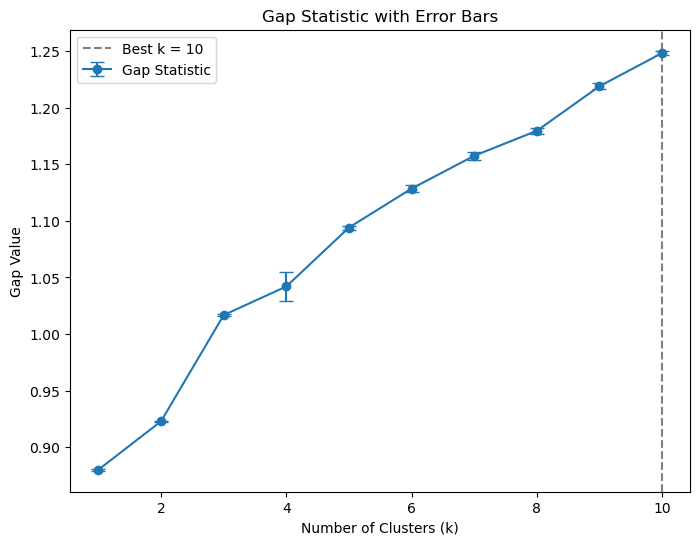

In [33]:
best_k, gaps, sk = gap_statistic(X_scaled, max_k=10, B=20, verbose=False)

K = range(1, len(gaps) + 1)

plt.figure(figsize=(8, 6))
plt.errorbar(K, gaps, yerr=sk, marker='o', capsize=5, label="Gap Statistic")
plt.axvline(x=best_k, linestyle='--', color='gray', label=f"Best k = {best_k}")
plt.title("Gap Statistic with Error Bars")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Gap Value")
plt.legend()
plt.show()

In [21]:
def plot_silhouette(k, X, title="Silhouette Plot"):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = kmeans.fit_predict(X)

    sil_vals = silhouette_samples(X, labels)
    sil_avg = silhouette_score(X, labels)
    
    print(f"Average Silhouette Score for k={k}: {sil_avg:.4f}")

    fig, ax = plt.subplots(figsize=(8, 6))

    y_lower = 10
    for i in range(k):
        ith_vals = sil_vals[labels == i]
        ith_vals.sort()
        size_i = ith_vals.shape[0]
        y_upper = y_lower + size_i

        color = cm.nipy_spectral(float(i) / k)
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                         0, ith_vals,
                         facecolor=color, edgecolor=color, alpha=0.7)

        ax.text(-0.05, y_lower + 0.5 * size_i, str(i))
        y_lower = y_upper + 10

    ax.axvline(x=sil_avg, color="green", linestyle="--")
    ax.set_xlim([-0.1, 1])
    ax.set_ylim([0, len(X) + (k + 1) * 10])
    ax.set_title(f"{title}")
    ax.set_xlabel("Silhouette coefficient values")
    ax.set_ylabel("Cluster labels")
    plt.tight_layout()
    plt.show()


Average Silhouette Score for k=3: 0.3450


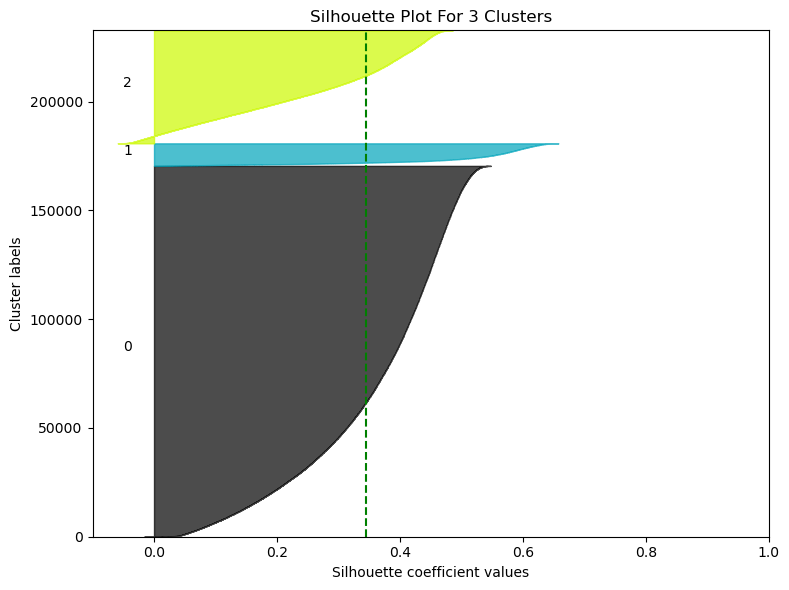

In [24]:
plot_silhouette(k=3, X=X_scaled, title="Silhouette Plot For 3 Clusters")

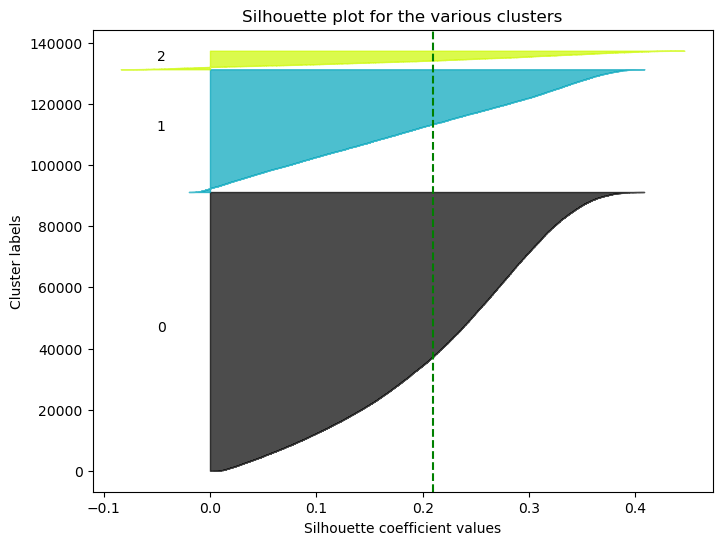

In [21]:
# Choose number of clusters
k = 3
kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
labels = kmeans.fit_predict(X_scaled_clean)

# Compute silhouette scores for each sample
sample_silhouette_values = silhouette_samples(X_scaled_clean, labels)
average_score = silhouette_score(X_scaled_clean, labels)

# Plot
fig, ax = plt.subplots(figsize=(8, 6))

y_lower = 10
for i in range(k):
    ith_cluster_values = sample_silhouette_values[labels == i]
    ith_cluster_values.sort()
    
    size_cluster_i = ith_cluster_values.shape[0]
    y_upper = y_lower + size_cluster_i
    
    color = cm.nipy_spectral(float(i) / k)
    ax.fill_betweenx(np.arange(y_lower, y_upper),
                     0, ith_cluster_values,
                     facecolor=color, edgecolor=color, alpha=0.7)
    
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10  # 10 for spacing between plots

# Add vertical line for average silhouette score
ax.axvline(x=average_score, color="green", linestyle="--")

ax.set_title("Silhouette plot for the various clusters")
ax.set_xlabel("Silhouette coefficient values")
ax.set_ylabel("Cluster labels")
plt.show()

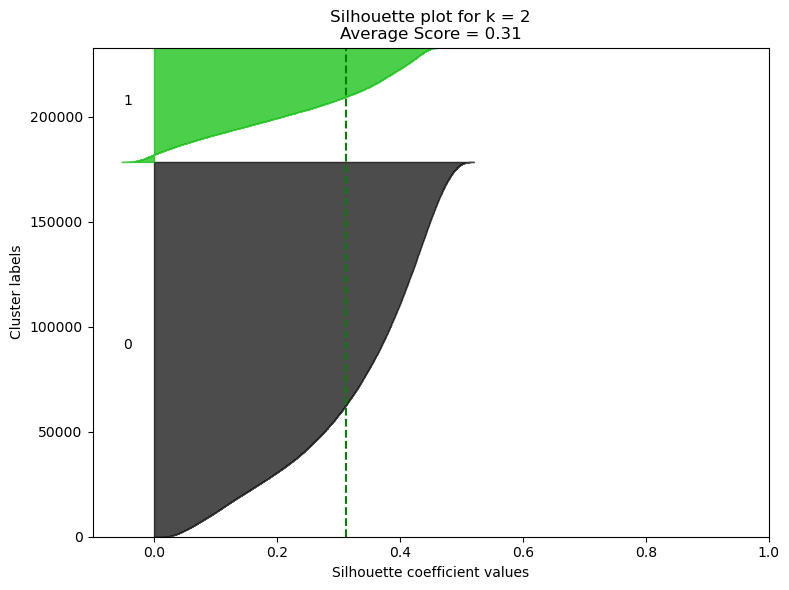

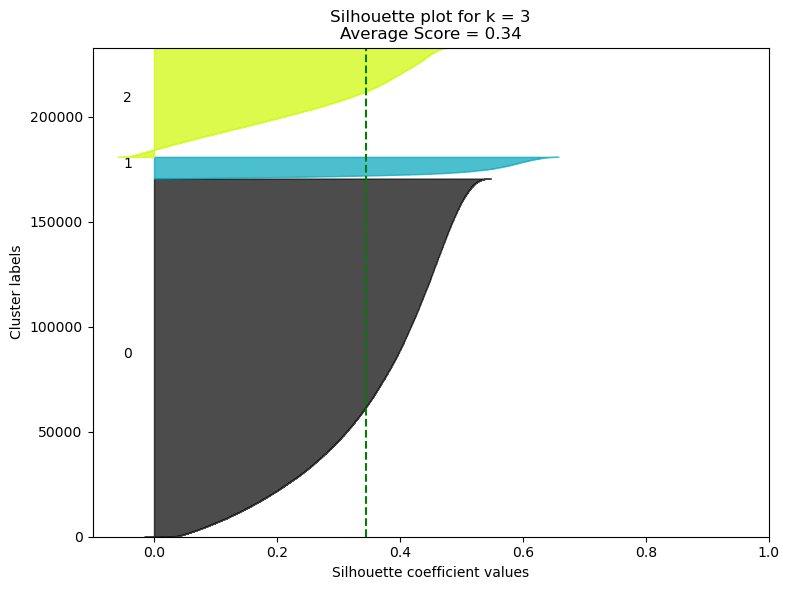

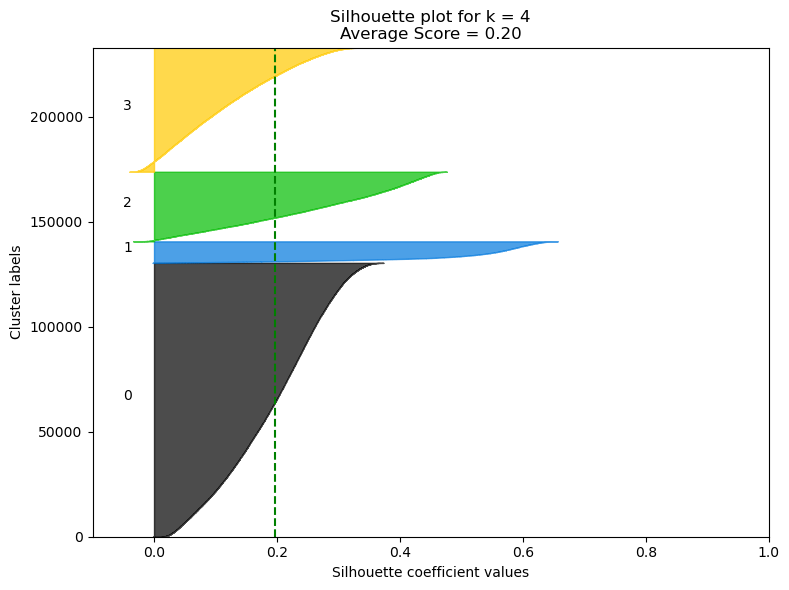

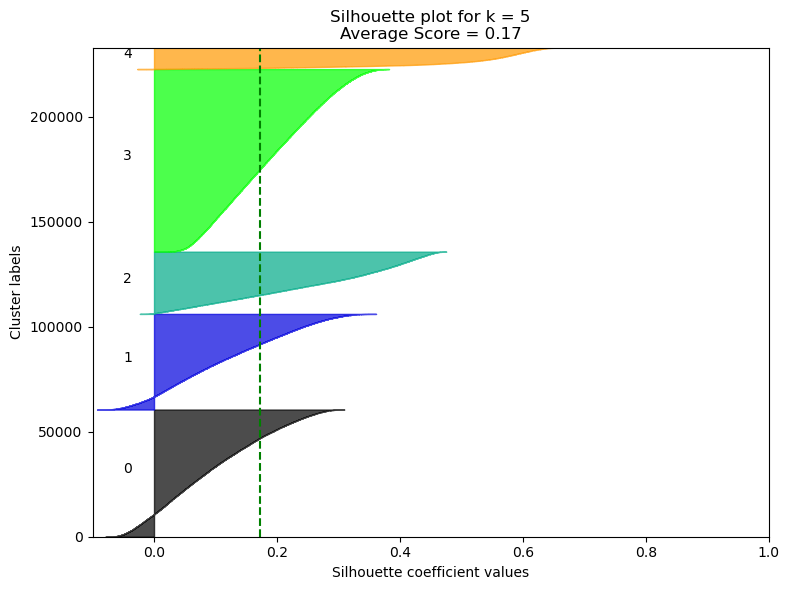

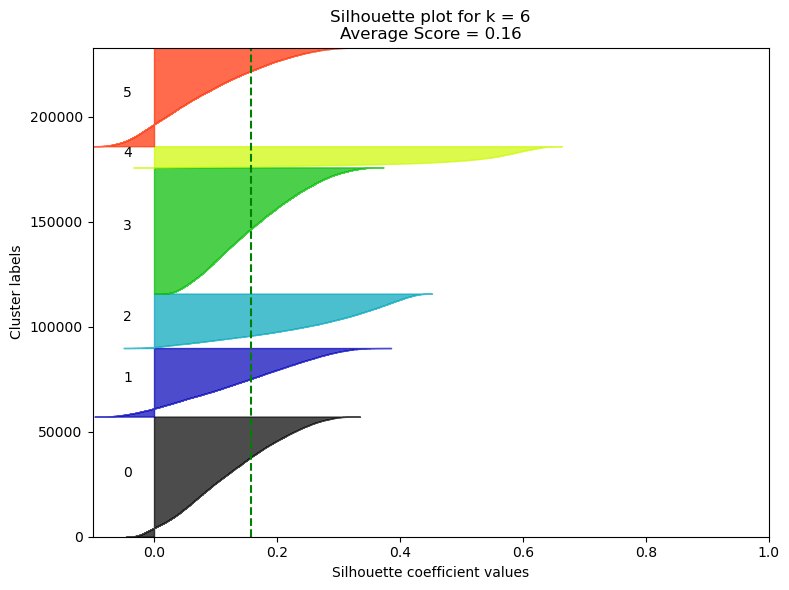

In [13]:
# Set k values to test
ks = range(2, 7)

for k in ks:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = kmeans.fit_predict(X_scaled)
    sil_avg = silhouette_score(X_scaled, labels)
    sil_vals = silhouette_samples(X_scaled, labels)

    # Create a new figure for each k
    fig, ax = plt.subplots(figsize=(8, 6))
    y_lower = 10

    for i in range(k):
        ith_vals = sil_vals[labels == i]
        ith_vals.sort()
        size_i = ith_vals.shape[0]
        y_upper = y_lower + size_i

        color = cm.nipy_spectral(float(i) / k)
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                         0, ith_vals,
                         facecolor=color, edgecolor=color, alpha=0.7)

        ax.text(-0.05, y_lower + 0.5 * size_i, str(i))
        y_lower = y_upper + 10

    ax.axvline(x=sil_avg, color="green", linestyle="--")
    ax.set_xlim([-0.1, 1])
    ax.set_ylim([0, len(X_scaled) + (k + 1) * 10])
    ax.set_title(f"Silhouette plot for k = {k}\nAverage Score = {sil_avg:.2f}")
    ax.set_xlabel("Silhouette coefficient values")
    ax.set_ylabel("Cluster labels")
    plt.tight_layout()
    plt.show()

In [40]:
k_values = list(range(2, 11))

metrics_df = pd.DataFrame({
    "k": k_values,
    "WCSS": wcss,                              
    "Silhouette": sil_scores,                  
    "Davies-Bouldin": dbi_scores,              
    "Calinski-Harabasz": ch_scores,            
    "Gap": gaps[1:len(k_values)+1],            
    "Gap s_k": sk[1:len(k_values)+1]           
})


metrics_df = metrics_df.round(3)
metrics_df

k         WCSS  Silhouette  Davies-Bouldin  Calinski-Harabasz    Gap  \
0   2  1722617.419       0.312           1.385          81685.187  0.923   
1   3  1429381.388       0.345           1.118          73092.391  1.017   
2   4  1291833.324       0.196           1.613          62176.352  1.042   
3   5  1176721.881       0.172           1.688          56885.077  1.094   
4   6  1100504.549       0.158           1.681          51883.196  1.129   
5   7  1036483.406       0.165           1.639          48302.126  1.158   
6   8   986227.753       0.163           1.608          45205.481  1.180   
7   9   926233.168       0.170           1.529          44000.866  1.219   
8  10   880848.107       0.166           1.538          42459.133  1.248   

   Gap s_k  
0    0.000  
1    0.001  
2    0.013  
3    0.002  
4    0.003  
5    0.004  
6    0.003  
7    0.003  
8    0.002

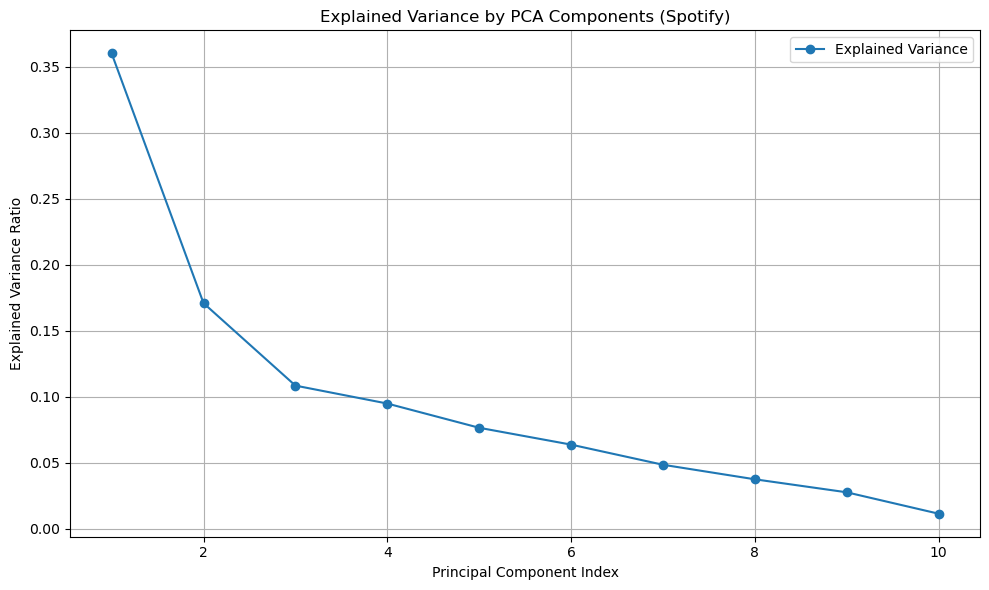

In [78]:
# plot explained variance for each PCA
n_feats = X_scaled.shape[1]
pca = PCA(n_components=n_feats, random_state=42)
pca.fit(X_scaled)
explained_var = pca.explained_variance_ratio_

# individual explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_feats + 1), explained_var, marker='o', label='Explained Variance')
plt.xlabel('Principal Component Index')
plt.ylabel('Explained Variance Ratio')
plt.title("Explained Variance by PCA Components (Spotify)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

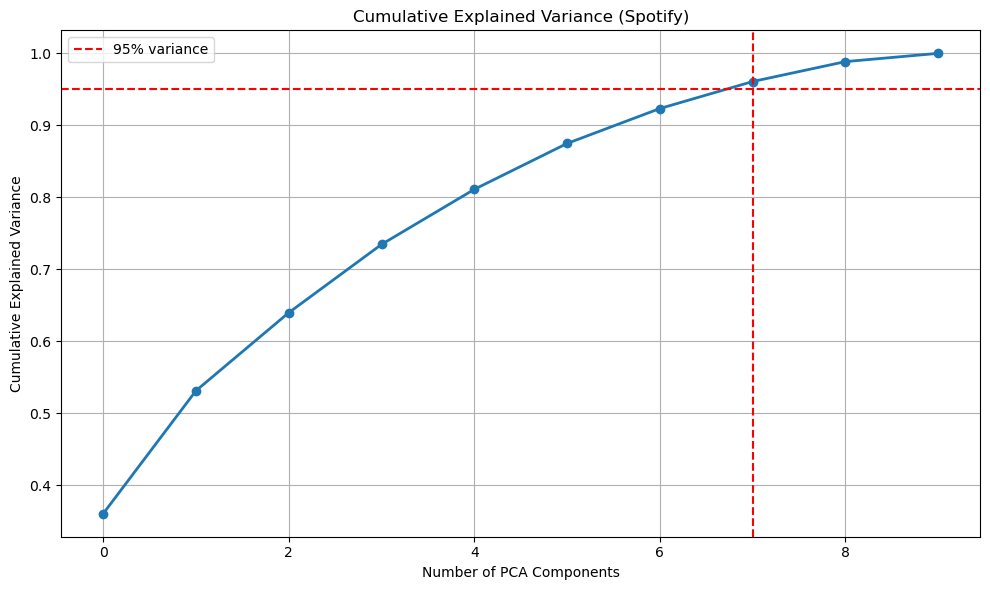

In [79]:
# plot cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(explained_var), marker='o', linewidth=2)
plt.xlabel('Number of PCA Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance (Spotify)')
plt.grid(True)

# plot red line at 95% threshold
plt.axhline(y=0.95, color='r', linestyle='--', label='95% variance')
plt.axvline(x=np.argmax(np.cumsum(explained_var) >= 0.95), color='r', linestyle='--')
plt.legend()
plt.tight_layout()
plt.show()

# KMeans Clustering

In [66]:
def run_kmeans(data, k, original_df=None, interpret=False):
    model = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = model.fit_predict(data)

    # Cluster sizes
    unique, counts = np.unique(labels, return_counts=True)
    cluster_sizes = dict(zip(unique, counts))
    print(f"Cluster Sizes (k={k}):")
    for cluster_id, size in cluster_sizes.items():
        print(f"  Cluster {cluster_id}: {size}")

    # Validation metrics
    sil_score_val = silhouette_score(data, labels)
    dbi_score_val = davies_bouldin_score(data, labels)
    chi_score_val = calinski_harabasz_score(data, labels)

    n_samples, n_features = data.shape
    print(f"\nK-Means Results on data with shape: {n_samples} samples × {n_features} features")
    print(f"Silhouette Score (Range -1 to 1)           : {sil_score_val:.3f}")
    print(f"Davies-Bouldin Index (Lower is better)     : {dbi_score_val:.3f}")
    print(f"Calinski-Harabasz Index (Higher is better) : {chi_score_val:.1f}")
    
    cluster_means = None
    df_temp = None
    if original_df is not None:
        df_temp = original_df.copy()
        df_temp['cluster'] = labels
        cluster_means = df_temp.groupby('cluster').mean()

        if interpret:
            print(f"\nCluster Feature Means (k={k}):\n")
            print(cluster_means.round(3))
            
    return {
        "labels": labels,
        "model": model,
        "cluster_sizes": cluster_sizes,
        "silhouette": sil_score_val,
        "dbi": dbi_score_val,
        "chi": chi_score_val,
        "cluster_means": cluster_means
    }

In [69]:
def plot_results(X_2d, cluster_labels, title="K-Means clustering (PCA 2D)"):
    plt.figure(figsize=(7, 5))
    plt.scatter(X_2d[:, 0], X_2d[:, 1], c=cluster_labels, s=8)
    plt.title(title)
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.colorbar(label="Cluster")
    plt.show()

## Using original data
### k = 3

In [68]:
# Kmeans on full data
print("Kmeans on Full Data")
kmeans_full = run_kmeans(X_scaled, 3, original_df=df, interpret=True)

Kmeans on Full Data
Cluster Sizes (k=3):
  Cluster 0: 170450
  Cluster 1: 10350
  Cluster 2: 51925

K-Means Results on data with shape: 232725 samples × 10 features
Silhouette Score (Range -1 to 1)           : 0.345
Davies-Bouldin Index (Lower is better)     : 1.118
Calinski-Harabasz Index (Higher is better) : 73092.4

Cluster Feature Means (k=3):

         popularity  acousticness  danceability  energy  instrumentalness  \
cluster                                                                     
0            45.991         0.203         0.611   0.676             0.065   
1            20.703         0.789         0.562   0.659             0.001   
2            29.235         0.827         0.365   0.210             0.451   

         liveness  loudness  speechiness    tempo  valence  
cluster                                                     
0           0.199    -6.958        0.097  122.324    0.528  
1           0.726   -12.008        0.866   98.440    0.417  
2           0.166  

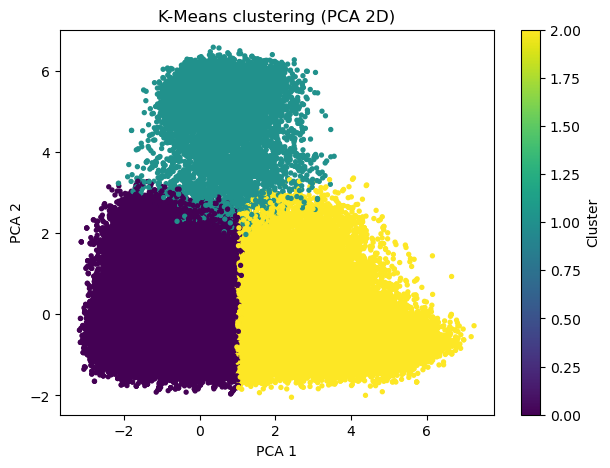

In [70]:
# PCA 2D for visualisation
pca_2d = PCA(n_components=2)
X_2d = pca_2d.fit_transform(X_scaled) 

plot_results(X_2d, kmeans_full['labels'], title="K-Means clustering (PCA 2D)")

In [71]:
# Kmeans on claned data
print("Kmeans on Cleaned Data")
kmeans_clean = run_kmeans(X_scaled_clean, 3, original_df=df_clean, interpret=True)

Kmeans on Cleaned Data
Cluster Sizes (k=3):
  Cluster 0: 91201
  Cluster 1: 40148
  Cluster 2: 6062

K-Means Results on data with shape: 137411 samples × 10 features
Silhouette Score (Range -1 to 1)           : 0.210
Davies-Bouldin Index (Lower is better)     : 1.606
Calinski-Harabasz Index (Higher is better) : 23705.3

Cluster Feature Means (k=3):

         popularity  acousticness  danceability  energy  instrumentalness  \
cluster                                                                     
0            47.504         0.123         0.615   0.743             0.001   
1            40.318         0.586         0.547   0.389             0.002   
2            43.336         0.262         0.567   0.633             0.055   

         liveness  loudness  speechiness    tempo  valence  
cluster                                                     
0           0.177    -5.794        0.075  123.663    0.558  
1           0.147   -10.452        0.050  113.971    0.403  
2           0.162 

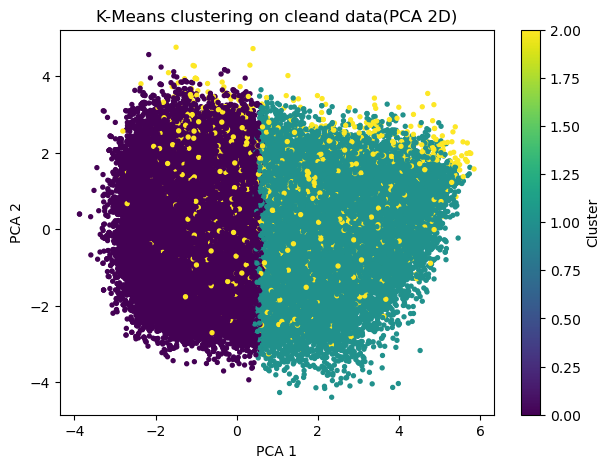

In [72]:
# PCA 2D for visualisation
pca_2d = PCA(n_components=2)
X_2d_clean = pca_2d.fit_transform(X_scaled_clean) 

plot_results(X_2d_clean, kmeans_clean['labels'], title="K-Means clustering on cleand data(PCA 2D)")

## PCA 2D

In [73]:
# Kmeans on PCA 2D full data 
pca_2d = PCA(n_components=2)
X_2d = pca_2d.fit_transform(X_scaled)

print("Kmeans on PCA 2D Data")
kmeans_2d = run_kmeans(X_2d, 3, original_df=df, interpret=True)

Kmeans on PCA 2D Data
Cluster Sizes (k=3):
  Cluster 0: 170296
  Cluster 1: 50900
  Cluster 2: 11529

K-Means Results on data with shape: 232725 samples × 2 features
Silhouette Score (Range -1 to 1)           : 0.600
Davies-Bouldin Index (Lower is better)     : 0.554
Calinski-Harabasz Index (Higher is better) : 292538.4

Cluster Feature Means (k=3):

         popularity  acousticness  danceability  energy  instrumentalness  \
cluster                                                                     
0            46.041         0.205         0.612   0.674             0.065   
1            29.262         0.826         0.363   0.207             0.459   
2            20.930         0.761         0.556   0.651             0.005   

         liveness  loudness  speechiness    tempo  valence  
cluster                                                     
0           0.196    -6.968        0.096  122.432    0.528  
1           0.161   -17.771        0.051  105.897    0.217  
2           0.738

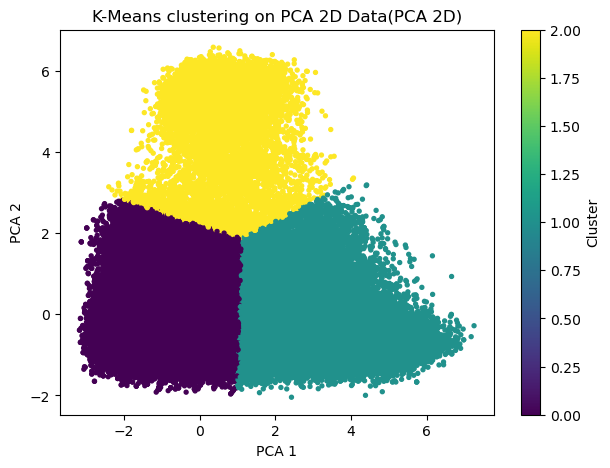

In [74]:
# PCA 2D for visualisation
plot_results(X_2d, kmeans_2d['labels'], title="K-Means clustering on PCA 2D Data(PCA 2D)")

In [80]:
# Kmeans on PCA 2D clean data 
pca_2d = PCA(n_components=2)
X_2d_clean = pca_2d.fit_transform(X_scaled_clean)

print("Kmeans on PCA 2D Cleaned Data")
kmeans_2d_clean = run_kmeans(X_2d_clean, 3, original_df=df_clean, interpret=True)

Kmeans on PCA 2D Cleaned Data
Cluster Sizes (k=3):
  Cluster 0: 52773
  Cluster 1: 35824
  Cluster 2: 48814

K-Means Results on data with shape: 137411 samples × 2 features
Silhouette Score (Range -1 to 1)           : 0.370
Davies-Bouldin Index (Lower is better)     : 0.921
Calinski-Harabasz Index (Higher is better) : 114864.6

Cluster Feature Means (k=3):

         popularity  acousticness  danceability  energy  instrumentalness  \
cluster                                                                     
0            46.473         0.194         0.720   0.678             0.002   
1            40.503         0.618         0.527   0.370             0.006   
2            47.329         0.081         0.504   0.783             0.004   

         liveness  loudness  speechiness    tempo  valence  
cluster                                                     
0           0.153    -6.721        0.083  114.194    0.669  
1           0.146   -10.693        0.047  113.017    0.367  
2         

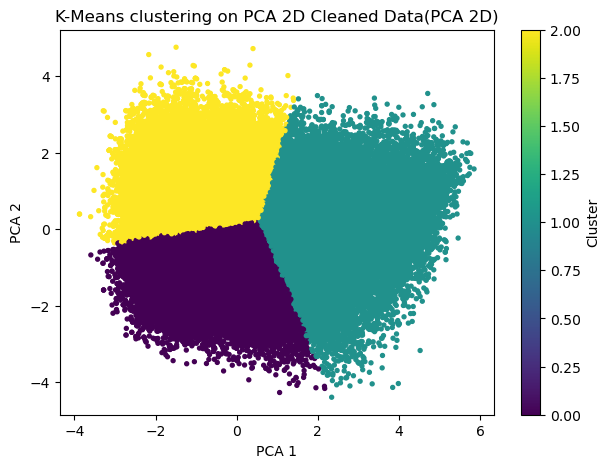

In [81]:
plot_results(X_2d_clean, kmeans_2d_clean['labels'], title="K-Means clustering on PCA 2D Cleaned Data(PCA 2D)")

## PCA 3D

In [83]:
# Kmeans on PCA 3D full data 
pca_3d = PCA(n_components=3)
X_3d = pca_3d.fit_transform(X_scaled)

print("Kmeans on PCA 3D Data")
kmeans_3d = run_kmeans(X_3d, 3, original_df=df, interpret=True)

Kmeans on PCA 3D Data
Cluster Sizes (k=3):
  Cluster 0: 169804
  Cluster 1: 51205
  Cluster 2: 11716

K-Means Results on data with shape: 232725 samples × 3 features
Silhouette Score (Range -1 to 1)           : 0.498
Davies-Bouldin Index (Lower is better)     : 0.717
Calinski-Harabasz Index (Higher is better) : 170571.2

Cluster Feature Means (k=3):

         popularity  acousticness  danceability  energy  instrumentalness  \
cluster                                                                     
0            46.064         0.204         0.612   0.675             0.065   
1            29.341         0.825         0.364   0.208             0.457   
2            21.091         0.754         0.553   0.653             0.005   

         liveness  loudness  speechiness    tempo  valence  
cluster                                                     
0           0.195    -6.961        0.096  122.438    0.529  
1           0.161   -17.730        0.051  105.949    0.218  
2           0.741

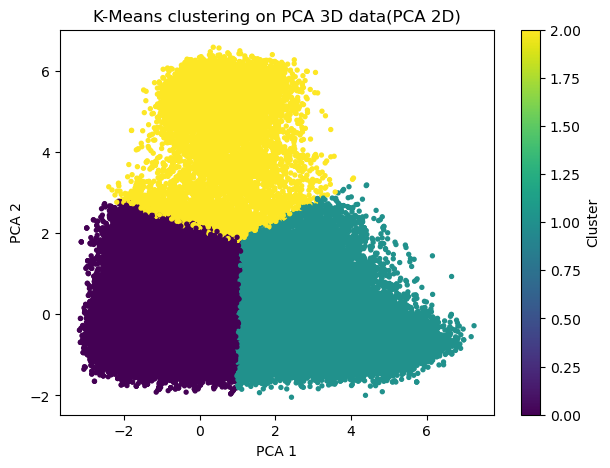

In [84]:
# PCA 2D for visualisation
pca_2d = PCA(n_components=2)
X_2d_from_3d = pca_2d.fit_transform(X_3d) 

plot_results(X_2d_from_3d, kmeans_3d['labels'], title="K-Means clustering on PCA 3D data(PCA 2D)")

In [85]:
# Kmeans on PCA 3D clean data 
pca_3d = PCA(n_components=3)
X_3d_clean = pca_3d.fit_transform(X_scaled_clean)

print("Kmeans on PCA 3D Cleaned Data")
kmeans_3d_clean = run_kmeans(X_3d_clean, 3, original_df=df_clean, interpret=True)

Kmeans on PCA 3D Cleaned Data
Cluster Sizes (k=3):
  Cluster 0: 46602
  Cluster 1: 35853
  Cluster 2: 54956

K-Means Results on data with shape: 137411 samples × 3 features
Silhouette Score (Range -1 to 1)           : 0.270
Davies-Bouldin Index (Lower is better)     : 1.273
Calinski-Harabasz Index (Higher is better) : 65879.2

Cluster Feature Means (k=3):

         popularity  acousticness  danceability  energy  instrumentalness  \
cluster                                                                     
0            44.958         0.081         0.500   0.796             0.005   
1            39.772         0.619         0.525   0.371             0.006   
2            48.998         0.188         0.716   0.671             0.002   

         liveness  loudness  speechiness    tempo  valence  
cluster                                                     
0           0.209    -5.279        0.066  135.811    0.470  
1           0.147   -10.716        0.047  113.537    0.374  
2          

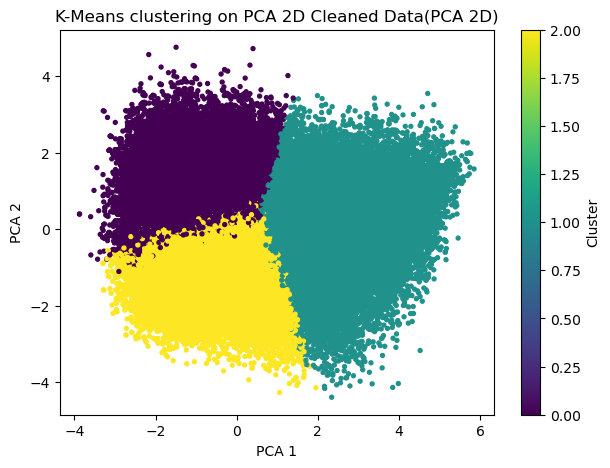

In [86]:
# PCA 2D for visualisation
pca_2d = PCA(n_components=2)
X_2d_from_3d_clean = pca_2d.fit_transform(X_3d_clean) 

plot_results(X_2d_from_3d_clean, kmeans_3d_clean['labels'], title="K-Means clustering on PCA 2D Cleaned Data(PCA 2D)")

### PCA Componenet VS Validation Metrics on FUll Data

In [102]:
# Store results
sil_results = {}
dbi_results = {}
chi_results = {}

pca_dimensions = [2, 3, 4, 5, 6, 7]

for dim in pca_dimensions:
    X_pca = PCA(n_components=dim, random_state=42).fit_transform(X_scaled)
    
    kmeans = KMeans(n_clusters=3, random_state=42, n_init='auto')
    labels = kmeans.fit_predict(X_pca)
    
    key = f"{dim}D"
    sil_results[key] = silhouette_score(X_pca, labels)
    dbi_results[key] = davies_bouldin_score(X_pca, labels)
    chi_results[key] = calinski_harabasz_score(X_pca, labels)

# Full data (no PCA)
full_key = f"{X_scaled.shape[1]}D"
kmeans_full = KMeans(n_clusters=3, random_state=42, n_init='auto')
labels_full = kmeans_full.fit_predict(X_scaled)

sil_results[full_key] = silhouette_score(X_scaled, labels_full)
dbi_results[full_key] = davies_bouldin_score(X_scaled, labels_full)
chi_results[full_key] = calinski_harabasz_score(X_scaled, labels_full)

In [104]:
k_means_spo_results_df = pd.DataFrame({
    "Silhouette": sil_results,
    "DBI": dbi_results,
    "CHI": chi_results
}).loc[[f"{d}D" for d in pca_dimensions] + [full_key]]

# Save to CSV
results_path = "k_means_spo_results.csv"
k_means_spo_results_df.to_csv(results_path, index=False)

print(f"Results saved to {results_path}")

Results saved to k_means_spo_results.csv


In [105]:
k_means_spo_results_df 

Silhouette       DBI            CHI
2D     0.600114  0.553938  292538.394417
3D     0.497797  0.716794  170571.224310
4D     0.437898  0.841203  125306.657534
5D     0.401789  0.931470  103286.025806
6D     0.384177  1.009875   90444.060277
7D     0.368966  1.040975   83045.554297
10D    0.344963  1.118007   73092.391273

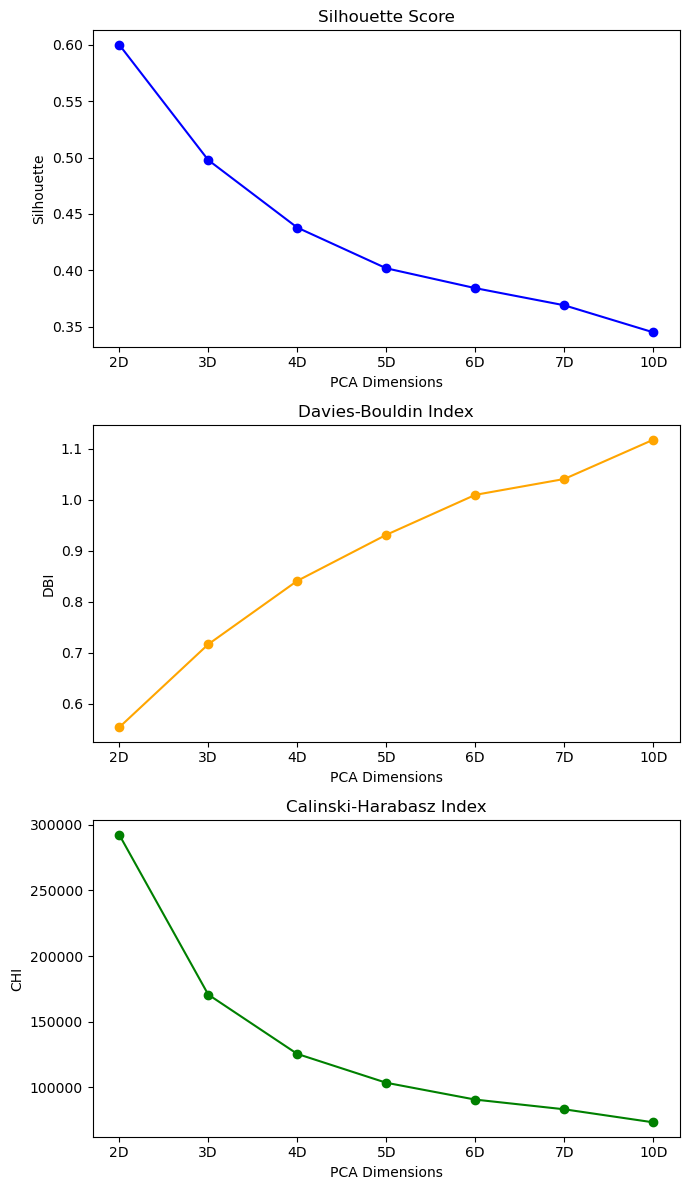

In [107]:
fig, axes = plt.subplots(3, 1, figsize=(7, 12))

axes[0].plot(k_means_spo_results_df.index, k_means_spo_results_df["Silhouette"], marker='o', color='blue')
axes[0].set_title("Silhouette Score")
axes[0].set_xlabel("PCA Dimensions")
axes[0].set_ylabel("Silhouette")

axes[1].plot(k_means_spo_results_df.index, k_means_spo_results_df["DBI"], marker='o', color='orange')
axes[1].set_title("Davies-Bouldin Index")
axes[1].set_xlabel("PCA Dimensions")
axes[1].set_ylabel("DBI")

axes[2].plot(k_means_spo_results_df.index, k_means_spo_results_df["CHI"], marker='o', color='green')
axes[2].set_title("Calinski-Harabasz Index")
axes[2].set_xlabel("PCA Dimensions")
axes[2].set_ylabel("CHI")

plt.tight_layout()
plt.show()

### PCA Componenet VS Validation Metrics on Removal Outliers Data

In [108]:
# Store results for cleaned dataset
sil_results_clean = {}
dbi_results_clean = {}
chi_results_clean = {}

pca_dimensions = [2, 3, 4, 5, 6, 7]

for dim in pca_dimensions:
    X_pca_clean = PCA(n_components=dim, random_state=42).fit_transform(X_scaled_clean)
    
    kmeans = KMeans(n_clusters=3, random_state=42, n_init='auto')
    labels_clean = kmeans.fit_predict(X_pca_clean)
    
    key = f"{dim}D"
    sil_results_clean[key] = silhouette_score(X_pca_clean, labels_clean)
    dbi_results_clean[key] = davies_bouldin_score(X_pca_clean, labels_clean)
    chi_results_clean[key] = calinski_harabasz_score(X_pca_clean, labels_clean)

# Full data (no PCA) baseline for cleaned dataset
full_key_clean = f"{X_scaled_clean.shape[1]}D"
kmeans_full_clean = KMeans(n_clusters=3, random_state=42, n_init='auto')
labels_full_clean = kmeans_full_clean.fit_predict(X_scaled_clean)

sil_results_clean[full_key_clean] = silhouette_score(X_scaled_clean, labels_full_clean)
dbi_results_clean[full_key_clean] = davies_bouldin_score(X_scaled_clean, labels_full_clean)
chi_results_clean[full_key_clean] = calinski_harabasz_score(X_scaled_clean, labels_full_clean)


In [109]:
k_means_spo_results_clean_df = pd.DataFrame({
    "Silhouette": sil_results_clean,
    "DBI": dbi_results_clean,
    "CHI": chi_results_clean
}).loc[[f"{d}D" for d in pca_dimensions] + [full_key_clean]]

# Save to CSV
results_path_clean = "k_means_spo_results_clean.csv"
k_means_spo_results_clean_df.to_csv(results_path_clean, index=False)

print(f"Cleaned results saved to {results_path_clean}")


Cleaned results saved to k_means_spo_results_clean.csv


In [ ]:
# store results
silhouette_scores = {}
dbi_scores = {}
chi_scores = {}

k_values = list(range(2, 11))  

# Full 10D (no PCA)
sil_vals, dbi_vals, chi_vals = [], [], []
for k in k_values:
    km = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = km.fit_predict(X_scaled)
    sil_vals.append(silhouette_score(X_scaled, labels))
    dbi_vals.append(davies_bouldin_score(X_scaled, labels))
    chi_vals.append(calinski_harabasz_score(X_scaled, labels))
silhouette_scores["Full_10D"] = sil_vals
dbi_scores["Full_10D"] = dbi_vals
chi_scores["Full_10D"] = chi_vals

# PCA 2..7
for d in [2, 3, 4, 5, 6, 7]:
    X_pca = PCA(n_components=d, random_state=42).fit_transform(X_scaled)
    sil_vals, dbi_vals, chi_vals = [], [], []
    for k in k_values:
        km = KMeans(n_clusters=k, random_state=42, n_init='auto')
        labels = km.fit_predict(X_pca)
        sil_vals.append(silhouette_score(X_pca, labels))
        dbi_vals.append(davies_bouldin_score(X_pca, labels))
        chi_vals.append(calinski_harabasz_score(X_pca, labels))
    silhouette_scores[f"PCA_{d}D"] = sil_vals
    dbi_scores[f"PCA_{d}D"] = dbi_vals
    chi_scores[f"PCA_{d}D"] = chi_vals

# DataFrames
kmeans_spo_sil_df = pd.DataFrame(silhouette_scores, index=k_values)
kmeans_spo_dbi_df = pd.DataFrame(dbi_scores,        index=k_values)
kmeans_spo_chi_df = pd.DataFrame(chi_scores,        index=k_values)

In [19]:
X_full = X_scaled
X_clean = X_scaled_clean
X_pca_2 = PCA(n_components=2, random_state=42).fit_transform(X_scaled)
X_pca_3 = PCA(n_components=3, random_state=42).fit_transform(X_scaled)

datasets = {
    "Full": X_full,
    "Cleaned": X_clean,
    "PCA_2": X_pca_2,
    "PCA_3": X_pca_3
}

# Track silhouette scores from k=1 to 10
k_values = range(1, 11)
silhouette_scores = {name: [] for name in datasets}

for name, X in datasets.items():
    for k in k_values:
        if k == 1:
            # Silhouette score is undefined for k=1, so append NaN
            silhouette_scores[name].append(np.nan)
        else:
            km = KMeans(n_clusters=k, random_state=42, n_init='auto')
            labels = km.fit_predict(X)
            score = silhouette_score(X, labels)
            silhouette_scores[name].append(score)

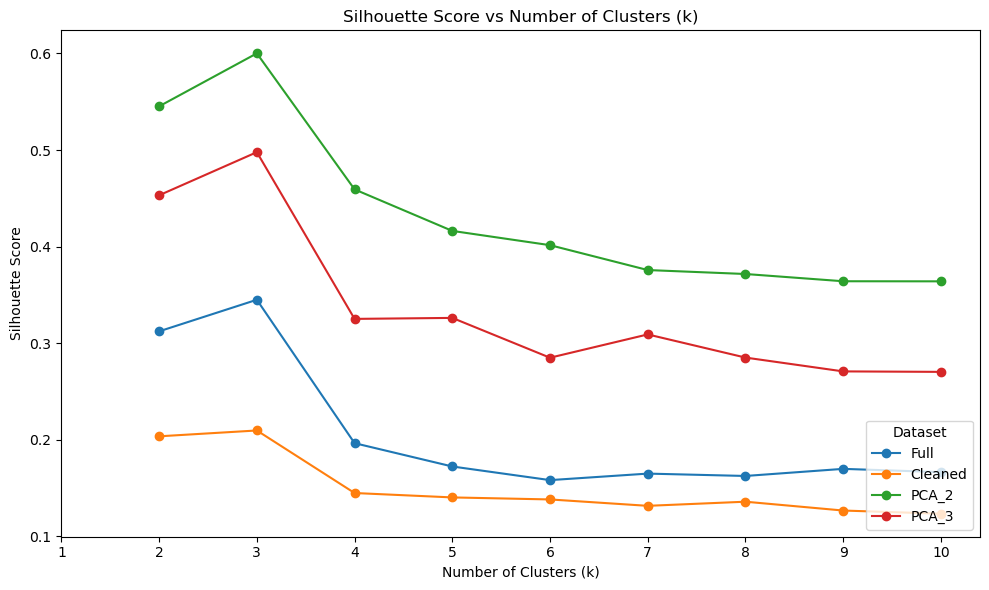

In [21]:
plt.figure(figsize=(10, 6))

for name, scores in silhouette_scores.items():
    plt.plot(k_values, scores, marker='o', label=name)

plt.title("Silhouette Score vs Number of Clusters (k)")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.xticks(k_values)
plt.legend(title="Dataset", loc='lower right')
plt.tight_layout()
plt.show()


# DBSCAN

Is big or small eps better?

Too small: Almost every point is an outlier (cluster = noise), few or zero clusters formed.

Too large: Merges everything into one big cluster, lose useful separation.

In [ ]:
def plot_k_distance_graph(X, k, title_prefix=""):
    nn = NearestNeighbors(n_neighbors=k)
    nn.fit(X)
    distances, _ = nn.kneighbors(X)
    k_distances_sorted = np.sort(distances[:, k - 1])

    plt.figure(figsize=(10, 6))
    plt.plot(k_distances_sorted)
    plt.xlabel("Data Points (sorted)")
    plt.ylabel(f"Distance to {k}-th Nearest Neighbor")
    plt.title(f"K-Distance Graph ({title_prefix}, k={k})")
    plt.grid(True)
    plt.show()

In [ ]:
def evaluate_dbscan(X, y=None, eps=0.5, min_samples=5):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(X)

    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    noise_points = int(np.sum(labels == -1))
    noise_pct = 100.0 * noise_points / len(labels)

    results = {
        "eps": eps,
        "min_samples": min_samples,
        "n_clusters": n_clusters,
        "noise_points": noise_points,
        "noise_pct": noise_pct,
        "labels": labels
    }

    if y is not None:
        results["ARI"] = adjusted_rand_score(y, labels)
        results["NMI"] = normalized_mutual_info_score(y, labels)

    # Silhouette score (only for non-noise points with ≥2 clusters)
    mask = labels != -1
    if mask.any() and len(set(labels[mask])) >= 2:
        results["silhouette"] = silhouette_score(X[mask], labels[mask])
    else:
        results["silhouette"] = None

    # prints
    print(f"DBSCAN Results ({X.shape[1]}D):")
    print(f"Clusters found: {n_clusters}")
    print(f"Noise points: {noise_points} ({noise_pct:.2f}%)")
    if y is not None:
        print(f"ARI: {results['ARI']:.4f}")
        print(f"NMI: {results['NMI']:.4f}")
    if results["silhouette"] is not None:
        print(f"Silhouette (non-noise): {results['silhouette']:.4f}")
    else:
        print("Silhouette (non-noise): N/A")

    return results

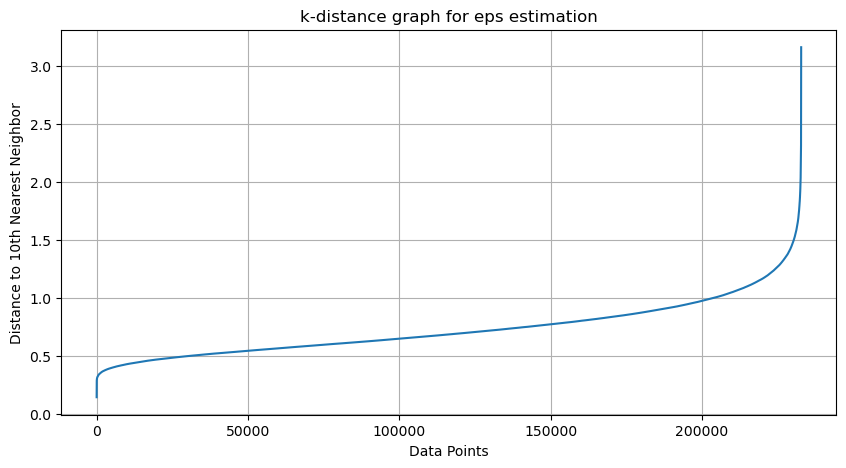

In [14]:
# K distance graph
k = 10
# Initializes the NearestNeighbors model to find the k-nearest neighbors
neigh = NearestNeighbors(n_neighbors=k)
nbrs = neigh.fit(X_scaled)
# Computes the distances to the k-nearest neighbors for each point
distances, indices = nbrs.kneighbors(X_scaled)

# Sort the distances to the k-th nearest neighbor
k_distances = np.sort(distances[:, -1])

plt.figure(figsize=(10, 5))
plt.plot(k_distances)
plt.title('k-distance graph for eps estimation')
plt.xlabel('Data Points')
plt.ylabel(f'Distance to {k}th Nearest Neighbor')
plt.grid(True)
plt.show()

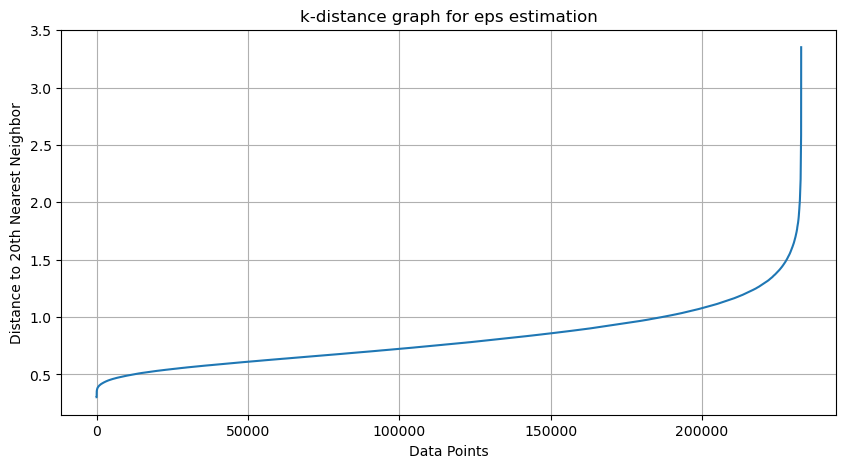

In [15]:
# K distance graph
k = 20
# Initializes the NearestNeighbors model to find the k-nearest neighbors
neigh = NearestNeighbors(n_neighbors=k)
nbrs = neigh.fit(X_scaled)
# Computes the distances to the k-nearest neighbors for each point
distances, indices = nbrs.kneighbors(X_scaled)

# Sort the distances to the k-th nearest neighbor
k_distances = np.sort(distances[:, -1])

plt.figure(figsize=(10, 5))
plt.plot(k_distances)
plt.title('k-distance graph for eps estimation')
plt.xlabel('Data Points')
plt.ylabel(f'Distance to {k}th Nearest Neighbor')
plt.grid(True)
plt.show()

In [43]:
eps = 0.8
min_samples = 10

db = DBSCAN(eps=eps, min_samples=min_samples)
labels = db.fit_predict(X_scaled_clean)

# Count clusters (excluding noise)
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)

print(f"Estimated number of clusters: {n_clusters}")
print(f"Estimated number of noise points: {n_noise}")

Estimated number of clusters: 181
Estimated number of noise points: 70722


In [50]:
eps_values = [0.8, 1.0, 1.2, 1.4, 1.6]
min_samples_values = [5, 10, 15, 20]

results = []

for eps in eps_values:
    for min_samples in min_samples_values:
        db = DBSCAN(eps=eps, min_samples=min_samples)
        labels = db.fit_predict(X_scaled)

        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = np.sum(labels == -1)
        sil = dbi = chi = None

        if n_clusters > 1:
            sil = silhouette_score(X_scaled, labels)
            dbi = davies_bouldin_score(X_scaled, labels)
            chi = calinski_harabasz_score(X_scaled, labels)

        results.append({
            'eps': eps,
            'min_samples': min_samples,
            'clusters': n_clusters,
            'noise_points': n_noise,
            'silhouette': sil,
            'dbi': dbi,
            'chi': chi
        })

dbscan_df = pd.DataFrame(results)

In [51]:
dbscan_df

eps  min_samples  clusters  noise_points  silhouette       dbi  \
0   0.8            5       539         30262   -0.529308  1.213427   
1   0.8           10        91         42895   -0.419218  1.361129   
2   0.8           15        29         52109   -0.331426  1.489817   
3   0.8           20        14         59684   -0.320946  1.863945   
4   1.0            5       132          9092   -0.350941  1.252970   
5   1.0           10        19         13031   -0.121837  1.518407   
6   1.0           15         5         16195    0.126677  2.145501   
7   1.0           20         3         18961    0.172993  2.423386   
8   1.2            5        33          2636   -0.193177  1.330832   
9   1.2           10         8          3891    0.005239  1.812708   
10  1.2           15         4          4917    0.162721  2.109440   
11  1.2           20         3          5767    0.195399  2.123056   
12  1.4            5         9           795   -0.000046  1.597441   
13  1.4           10         1          1133         NaN       NaN   
14  1.4           15         1          1411         NaN       NaN   
15  1.4           20         1          1696         NaN       NaN   
16  1.6            5         2           232    0.195317  2.068275   
17  1.6           10         1           321         NaN       NaN   
18  1.6           15         1           413         NaN       NaN   
19  1.6           20         1           489         NaN       NaN   

             chi  
0      69.999827  
1     368.811190  
2    1092.913968  
3    2181.653133  
4     266.947165  
5    1834.636403  
6    6986.691051  
7   11632.827341  
8      37.214577  
9     187.942282  
10   8538.349889  
11  11459.501430  
12     53.937613  
13           NaN  
14           NaN  
15           NaN  
16     80.785804  
17           NaN  
18           NaN  
19           NaN

In [47]:
eps_values = [0.8, 1.0, 1.2, 1.4, 1.6]
min_samples_values = [5, 10, 15, 20]

results = []

for eps in eps_values:
    for min_samples in min_samples_values:
        db = DBSCAN(eps=eps, min_samples=min_samples)
        labels = db.fit_predict(X_scaled_clean)

        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = np.sum(labels == -1)
        sil = dbi = chi = None

        if n_clusters > 1:
            sil = silhouette_score(X_scaled_clean, labels)
            dbi = davies_bouldin_score(X_scaled_clean, labels)
            chi = calinski_harabasz_score(X_scaled_clean, labels)

        results.append({
            'eps': eps,
            'min_samples': min_samples,
            'clusters': n_clusters,
            'noise_points': n_noise,
            'silhouette': sil,
            'dbi': dbi,
            'chi': chi
        })

dbscan_clean_df = pd.DataFrame(results)

In [49]:
dbscan_clean_df

eps  min_samples  clusters  noise_points  silhouette       dbi  \
0   0.8            5      1231         53157   -0.544141  1.235452   
1   0.8           10       181         70722   -0.507664  1.389190   
2   0.8           15        54         80742   -0.468807  1.546902   
3   0.8           20        17         87551   -0.376689  1.810227   
4   1.0            5       559         22863   -0.481029  1.214447   
5   1.0           10        69         31891   -0.380832  1.443384   
6   1.0           15        33         37631   -0.339570  1.512162   
7   1.0           20        17         42325   -0.251369  1.663351   
8   1.2            5       211          9337   -0.378016  1.213657   
9   1.2           10        40         13592   -0.134512  1.370001   
10  1.2           15        10         16298   -0.077489  1.632406   
11  1.2           20         5         18431   -0.012358  1.931581   
12  1.4            5        83          3657   -0.247723  1.190761   
13  1.4           10         7          5357    0.067263  1.581756   
14  1.4           15         6          6711   -0.007219  1.576710   
15  1.4           20         6          7948    0.057365  1.701770   
16  1.6            5        32          1461   -0.060485  1.286254   
17  1.6           10         3          2158    0.175847  1.797448   
18  1.6           15         1          2693         NaN       NaN   
19  1.6           20         1          3185         NaN       NaN   

            chi  
0     12.204900  
1     41.136547  
2    110.489639  
3    303.683532  
4     19.891371  
5    101.631101  
6    208.017888  
7    400.987881  
8     37.872453  
9    187.873726  
10   697.976441  
11  1379.952939  
12    51.082972  
13   642.081896  
14   925.392302  
15  1076.118586  
16    74.667358  
17   888.752656  
18          NaN  
19          NaN

### eps=1.0, min_samples=10

In [44]:
db = DBSCAN(eps=1.0, min_samples=10)
labels = db.fit_predict(X_scaled)

# Count cluster labels including noise (-1)
label_counts = pd.Series(labels).value_counts().sort_index()
print("DBSCAN Cluster Counts (including noise):\n")
print(label_counts)

# Optional: Count actual clusters and noise
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = np.sum(labels == -1)

print(f"\nEstimated number of clusters: {n_clusters}")
print(f"Estimated number of noise points: {n_noise}")

DBSCAN Cluster Counts (including noise):

-1      13031
 0     210879
 1       8650
 2         11
 3         11
 4          7
 5         16
 6         11
 7          5
 8         10
 9          6
 10         7
 11        21
 12        12
 13        10
 14         6
 15         8
 16         8
 17         8
 18         8
dtype: int64

Estimated number of clusters: 19
Estimated number of noise points: 13031


In [21]:
# Initial DBSCAN
db = DBSCAN(eps=1.0, min_samples=10)
spotify_df['dbscan_cluster'] = db.fit_predict(X_scaled)

# Count clusters and noise
print(spotify_df['dbscan_cluster'].value_counts())

 0     210879
-1      13031
 1       8650
 11        21
 5         16
 12        12
 3         11
 6         11
 2         11
 8         10
 13        10
 17         8
 15         8
 16         8
 18         8
 4          7
 10         7
 9          6
 14         6
 7          5
Name: dbscan_cluster, dtype: int64


C:\Users\Admin\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


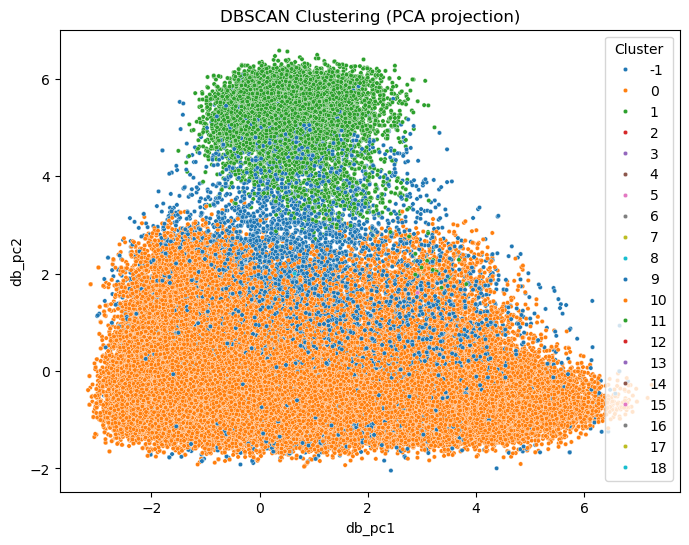

In [22]:
pca = PCA(n_components=2)
pc_db = pca.fit_transform(X_scaled)
spotify_df['db_pc1'], spotify_df['db_pc2'] = pc_db[:, 0], pc_db[:, 1]

plt.figure(figsize=(8,6))
sns.scatterplot(x='db_pc1', y='db_pc2', hue='dbscan_cluster',
                palette='tab10', data=spotify_df, s=10)
plt.title('DBSCAN Clustering (PCA projection)')
plt.legend(title='Cluster')
plt.show()

### eps=1.2, min_samples=20

In [23]:
# Initial DBSCAN
db = DBSCAN(eps=1.2, min_samples=20)
spotify_df['dbscan_cluster'] = db.fit_predict(X_scaled)

# Count clusters and noise
print(spotify_df['dbscan_cluster'].value_counts())

 0    217899
 1      9034
-1      5767
 2        25
Name: dbscan_cluster, dtype: int64


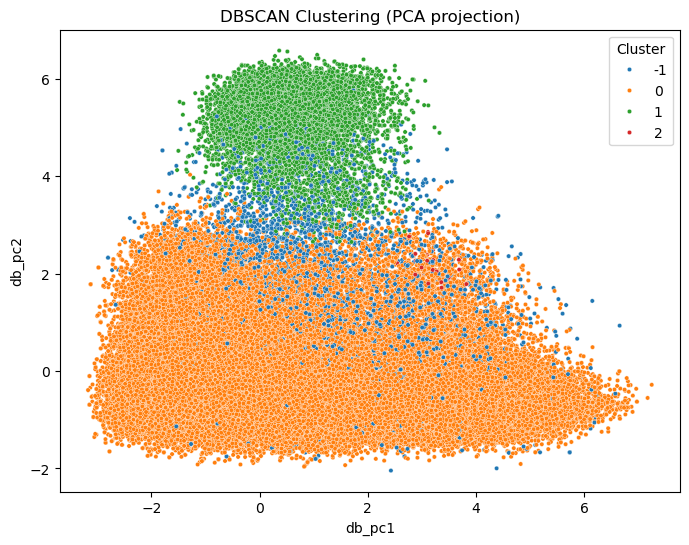

In [24]:
pca = PCA(n_components=2)
pc_db = pca.fit_transform(X_scaled)
spotify_df['db_pc1'], spotify_df['db_pc2'] = pc_db[:, 0], pc_db[:, 1]

plt.figure(figsize=(8,6))
sns.scatterplot(x='db_pc1', y='db_pc2', hue='dbscan_cluster',
                palette='tab10', data=spotify_df, s=10)
plt.title('DBSCAN Clustering (PCA projection)')
plt.legend(title='Cluster')
plt.show()

### eps=1.5, min_samples=10

In [16]:
# Initial DBSCAN
db = DBSCAN(eps=1.5, min_samples=10)
spotify_df['dbscan_cluster'] = db.fit_predict(X_scaled)

# Count clusters and noise
print(spotify_df['dbscan_cluster'].value_counts())

 0    232093
-1       632
Name: dbscan_cluster, dtype: int64


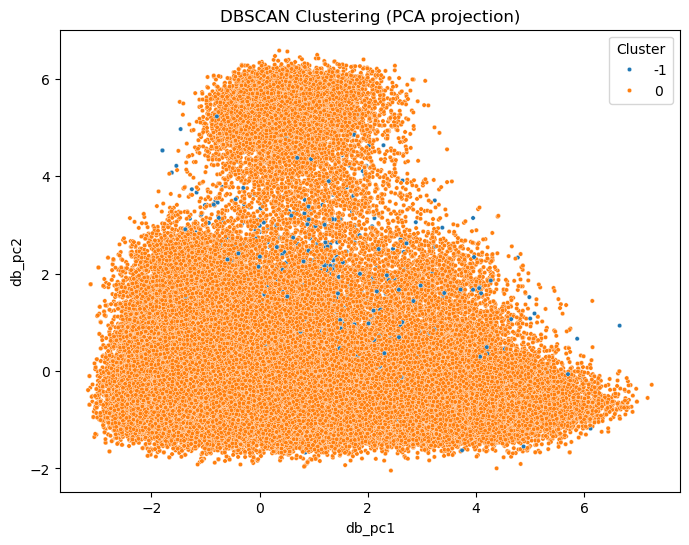

In [17]:
pca = PCA(n_components=2)
pc_db = pca.fit_transform(X_scaled)
spotify_df['db_pc1'], spotify_df['db_pc2'] = pc_db[:, 0], pc_db[:, 1]

plt.figure(figsize=(8,6))
sns.scatterplot(x='db_pc1', y='db_pc2', hue='dbscan_cluster',
                palette='tab10', data=spotify_df, s=10)
plt.title('DBSCAN Clustering (PCA projection)')
plt.legend(title='Cluster')
plt.show()

### eps=1.5, min_samples=20

In [18]:
# Initial DBSCAN
db = DBSCAN(eps=1.5, min_samples=20)
spotify_df['dbscan_cluster'] = db.fit_predict(X_scaled)

# Count clusters and noise
print(spotify_df['dbscan_cluster'].value_counts())

 0    231828
-1       897
Name: dbscan_cluster, dtype: int64


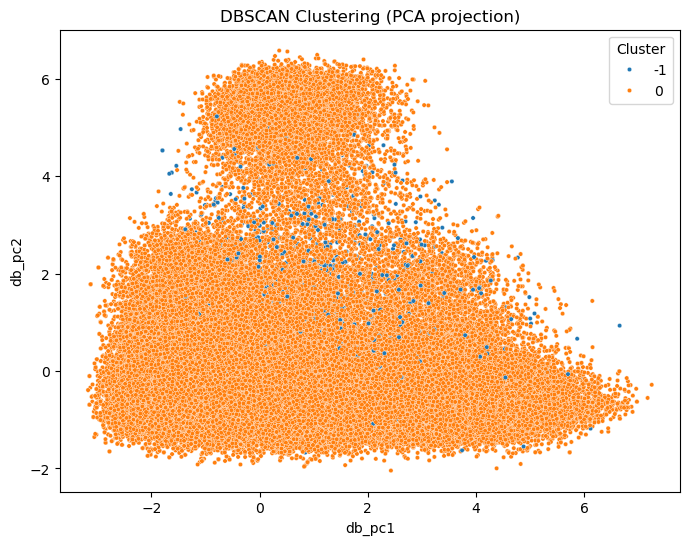

In [19]:
pca = PCA(n_components=2)
pc_db = pca.fit_transform(X_scaled)
spotify_df['db_pc1'], spotify_df['db_pc2'] = pc_db[:, 0], pc_db[:, 1]

plt.figure(figsize=(8,6))
sns.scatterplot(x='db_pc1', y='db_pc2', hue='dbscan_cluster',
                palette='tab10', data=spotify_df, s=10)
plt.title('DBSCAN Clustering (PCA projection)')
plt.legend(title='Cluster')
plt.show()

In [ ]:
X_sample, labels_sample = resample(X_scaled, spotify_df['dbscan_cluster'], n_samples=10000, random_state=42)
mask = labels_sample != -1
print("Silhouette Score (DBSCAN):", silhouette_score(X_sample[mask], labels_sample[mask]))

# Agglomerative Hierarchical Clustering

In [29]:
complete_clustering = linkage(X_scaled, method="complete", metric="euclidean")
average_clustering = linkage(X_scaled, method="average", metric="euclidean")
single_clustering = linkage(X_scaled, method="single", metric="euclidean")
ward_clustering = linkage(X_scaled, method="ward", metric="euclidean")

MemoryError: Unable to allocate 202. GiB for an array with shape (27080346450,) and data type float64

#### Resample the num of data

In [15]:
X_sample = resample(X_scaled, n_samples=10000, random_state=42)

In [16]:
complete_clustering = linkage(X_sample, method="complete", metric="euclidean")
average_clustering = linkage(X_sample, method="average", metric="euclidean")
ward_clustering = linkage(X_sample, method="ward", metric="euclidean")

#### Plot Dendogram

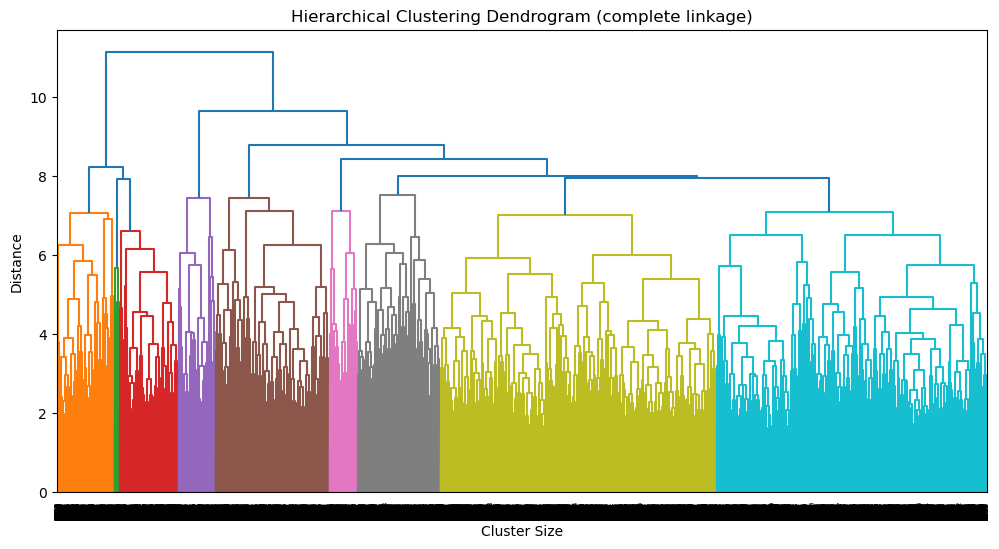

In [17]:
plt.figure(figsize=(12, 6))
dendrogram(complete_clustering)
plt.title('Hierarchical Clustering Dendrogram (complete linkage)')
plt.xlabel('Cluster Size')
plt.ylabel('Distance')
plt.show()

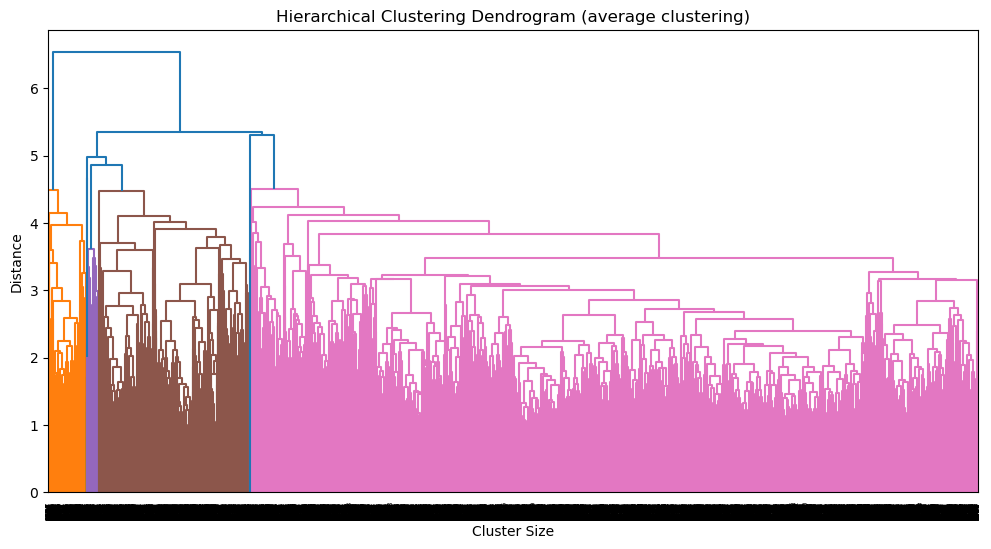

In [18]:
plt.figure(figsize=(12, 6))
dendrogram(average_clustering)
plt.title('Hierarchical Clustering Dendrogram (average clustering)')
plt.xlabel('Cluster Size')
plt.ylabel('Distance')
plt.show()

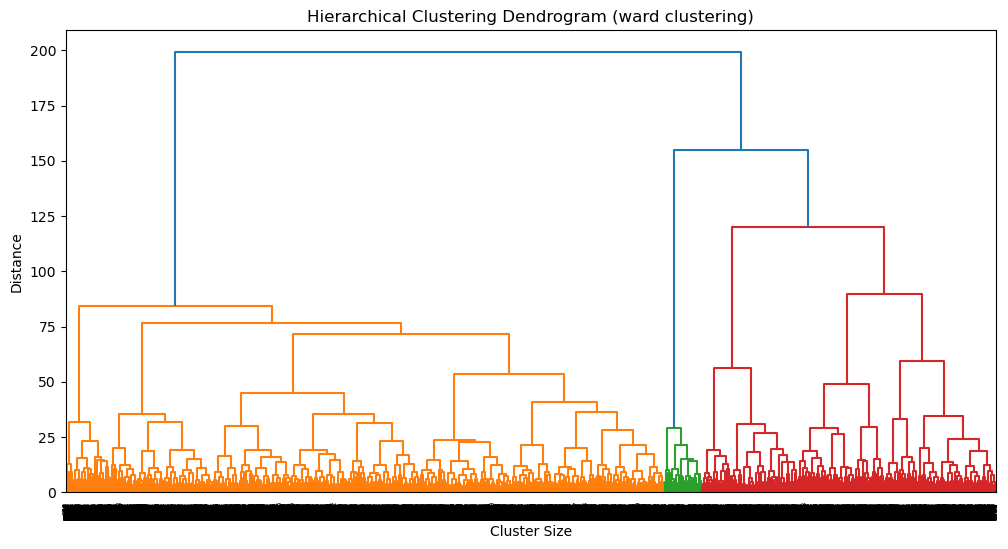

In [17]:
plt.figure(figsize=(12, 6))
dendrogram(ward_clustering)
plt.title('Hierarchical Clustering Dendrogram (ward clustering)')
plt.xlabel('Cluster Size')
plt.ylabel('Distance')
plt.show()

In [15]:
X_sample = resample(X_scaled, n_samples=5000, random_state=42)
single_clustering = linkage(X_sample, method="single", metric="euclidean")

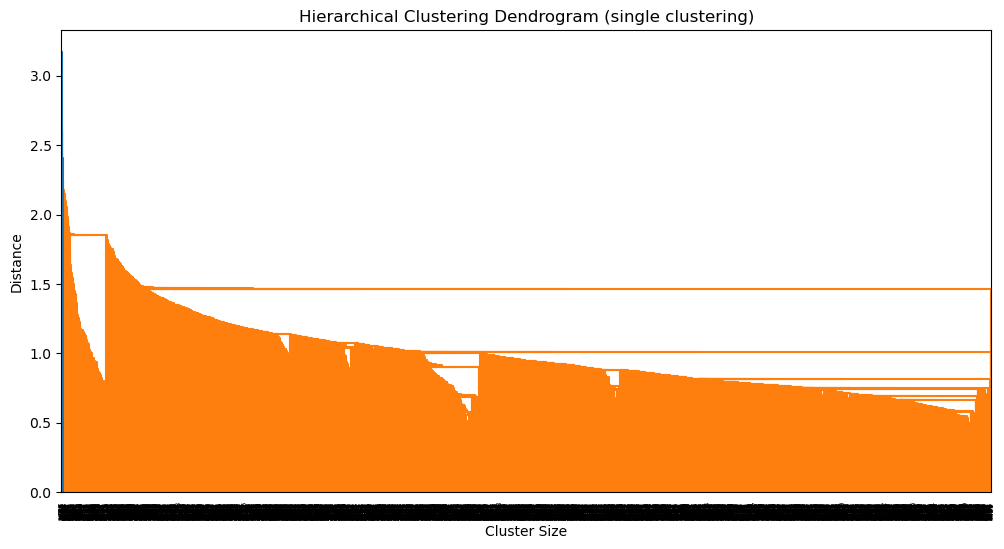

In [16]:
plt.figure(figsize=(12, 6))
dendrogram(single_clustering)
plt.title('Hierarchical Clustering Dendrogram (single clustering)')
plt.xlabel('Cluster Size')
plt.ylabel('Distance')
plt.show()

#### Fit to agglomerative clustering

In [18]:
# Fit model with 3 clusters
X_sample = resample(X_scaled, n_samples=10000, random_state=42)
agglo = AgglomerativeClustering(n_clusters=3, linkage='ward')
labels = agglo.fit_predict(X_sample)

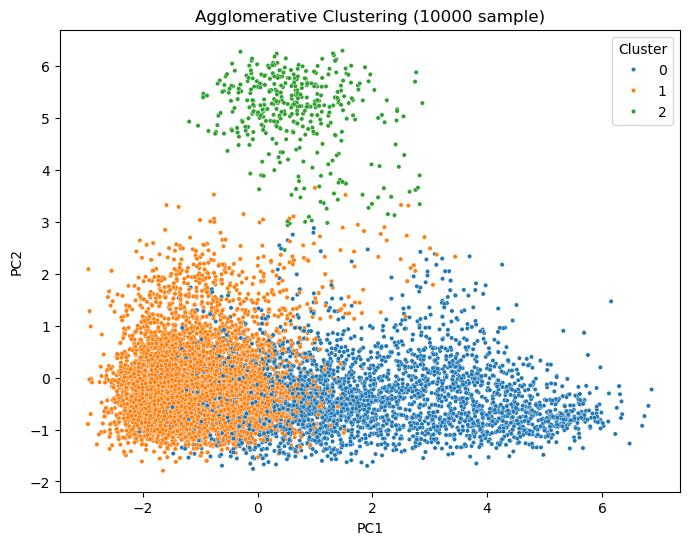

In [19]:
pca = PCA(n_components=2)
pc_sample = pca.fit_transform(X_sample)

plt.figure(figsize=(8,6))
sns.scatterplot(x=pc_sample[:,0], y=pc_sample[:,1], hue=labels, palette='tab10', s=10)
plt.title('Agglomerative Clustering (10000 sample)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(title='Cluster')
plt.show()

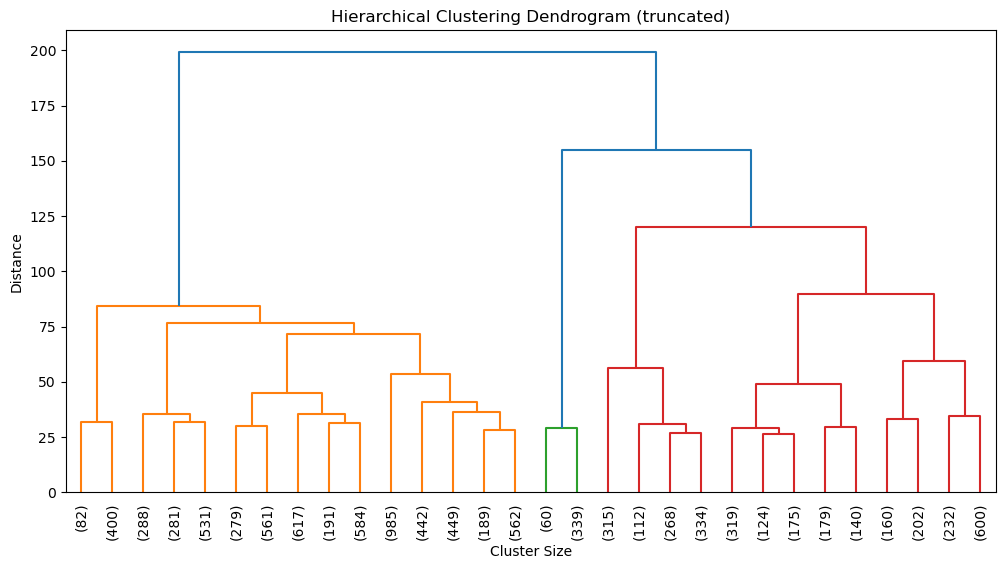

In [20]:
Z = linkage(X_sample, method='ward')
plt.figure(figsize=(12, 6))
dendrogram(Z, truncate_mode='lastp', p=30, leaf_rotation=90, leaf_font_size=10)
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('Cluster Size')
plt.ylabel('Distance')
plt.show()


# GMM

In [23]:
n_components_range = range(2, 15)
gmm_covariance_types = ['full', 'tied', 'diag', 'spherical']

# Store results in a dictionary
bic_results = {}
aic_results = {}

for cov in gmm_covariance_types:
    bic_scores = []
    aic_scores = []
    for k in n_components_range:
        gmm = GaussianMixture(n_components=k, covariance_type=cov, random_state=42)
        gmm.fit(X_scaled)
        bic_scores.append(gmm.bic(X_scaled))
        aic_scores.append(gmm.aic(X_scaled))
    bic_results[cov] = bic_scores
    aic_results[cov] = aic_scores


In [28]:
gmm_bic_aic_spo_df = pd.DataFrame([
    {"Covariance_Type": cov, 
     "n_components": k, 
     "BIC": bic_results[cov][i], 
     "AIC": aic_results[cov][i]}
    for cov in gmm_covariance_types
    for i, k in enumerate(n_components_range)
])

# Save to CSV
results_path = "gmm_bic_aic_spo_results.csv"
gmm_bic_aic_spo_df.to_csv(results_path, index=False)

print(f"Results saved to {results_path}")

Results saved to gmm_bic_aic_spo_results.csv


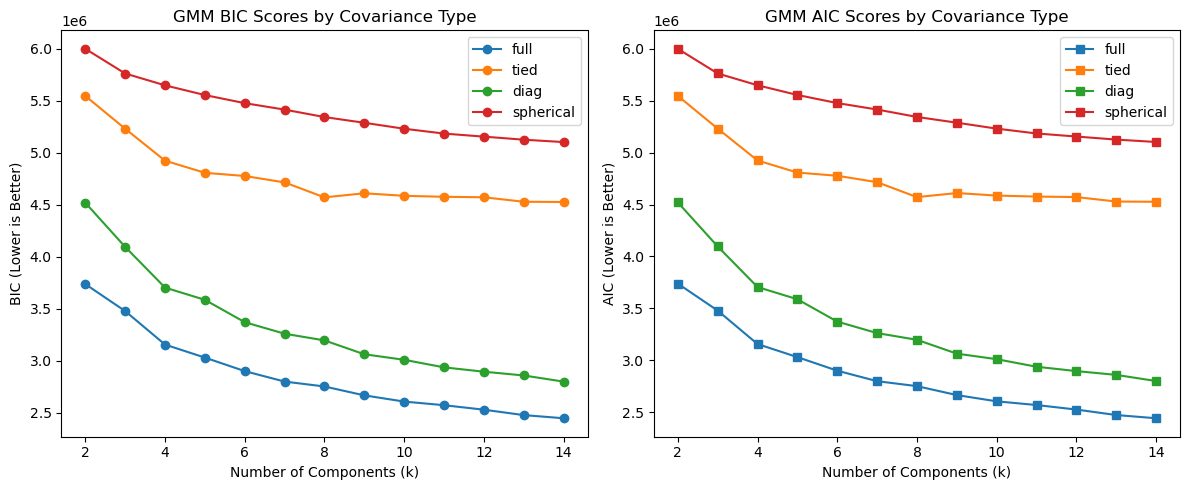

In [30]:
plt.figure(figsize=(12, 5))

# --- BIC Plot ---
plt.subplot(1, 2, 1)
for cov in gmm_covariance_types:
    plt.plot(n_components_range, bic_results[cov], marker='o', label=cov)
plt.title("GMM BIC Scores by Covariance Type")
plt.xlabel("Number of Components (k)")
plt.ylabel("BIC (Lower is Better)")
plt.legend()

# --- AIC Plot ---
plt.subplot(1, 2, 2)
for cov in gmm_covariance_types:
    plt.plot(n_components_range, aic_results[cov], marker='s', label=cov)
plt.title("GMM AIC Scores by Covariance Type")
plt.xlabel("Number of Components (k)")
plt.ylabel("AIC (Lower is Better)")
plt.legend()

plt.tight_layout()
plt.show()

In [18]:
n_components_range = range(2, 15)
gmm_covariance_types = ['full', 'tied', 'diag', 'spherical']

# Store GMM results
# Initialize result storage
sil_GMM_results = {}
dbi_GMM_results = {}
chi_GMM_results = {}

for cov in gmm_covariance_types:
    print(f"\n Running GMM evaluation for covariance_type = '{cov}'...")
    
    sil_scores = []
    dbi_scores = []
    chi_scores = []
    
    for k in n_components_range:
        gmm = GaussianMixture(n_components=k, covariance_type=cov, random_state=42)
        labels = gmm.fit_predict(X_scaled)

        sil = silhouette_score(X_scaled, labels)
        dbi = davies_bouldin_score(X_scaled, labels)
        chi = calinski_harabasz_score(X_scaled, labels)

        sil_scores.append(sil)
        dbi_scores.append(dbi)
        chi_scores.append(chi)

        print(f"  k = {k:2d} | Sil: {sil:.3f} | DBI: {dbi:.3f} | CHI: {chi:.1f}")
    
    # Save for later use
    sil_GMM_results[cov] = sil_scores
    dbi_GMM_results[cov] = dbi_scores
    chi_GMM_results[cov] = chi_scores

    print(f"Finished '{cov}' covariance type.")


 Running GMM evaluation for covariance_type = 'full'...
  k =  2 | Sil: 0.118 | DBI: 2.741 | CHI: 26876.3
  k =  3 | Sil: 0.065 | DBI: 4.013 | CHI: 19449.4
  k =  4 | Sil: 0.055 | DBI: 3.108 | CHI: 27547.5
  k =  5 | Sil: 0.044 | DBI: 3.544 | CHI: 20684.2
  k =  6 | Sil: -0.003 | DBI: 3.499 | CHI: 17457.5
  k =  7 | Sil: -0.001 | DBI: 3.542 | CHI: 16421.8
  k =  8 | Sil: -0.019 | DBI: 3.586 | CHI: 17680.0
  k =  9 | Sil: -0.014 | DBI: 3.455 | CHI: 17056.0
  k = 10 | Sil: -0.010 | DBI: 4.872 | CHI: 18328.8
  k = 11 | Sil: -0.005 | DBI: 4.249 | CHI: 17420.9
  k = 12 | Sil: -0.016 | DBI: 5.326 | CHI: 16366.4
  k = 13 | Sil: -0.009 | DBI: 4.044 | CHI: 15829.2
  k = 14 | Sil: -0.012 | DBI: 4.614 | CHI: 14989.0
Finished 'full' covariance type.

 Running GMM evaluation for covariance_type = 'tied'...
  k =  2 | Sil: 0.233 | DBI: 1.704 | CHI: 61857.2
  k =  3 | Sil: 0.265 | DBI: 1.383 | CHI: 57681.8
  k =  4 | Sil: 0.222 | DBI: 1.609 | CHI: 50439.1
  k =  5 | Sil: 0.211 | DBI: 1.521 | CHI: 45

In [20]:
# Combine all scores into a single DataFrame
gmm_eval_spo_df = pd.DataFrame([
    {
        "Covariance_Type": cov,
        "n_components": k,
        "Silhouette": sil_GMM_results[cov][i],
        "DBI": dbi_GMM_results[cov][i],
        "CHI": chi_GMM_results[cov][i]
    }
    for cov in gmm_covariance_types
    for i, k in enumerate(n_components_range)
])

# Save to CSV
results_path = "gmm_eval_spo_results.csv"
gmm_eval_spo_df.to_csv(results_path, index=False)

print(f"GMM evaluation results saved to '{results_path}'")

GMM evaluation results saved to 'gmm_eval_spo_results.csv'


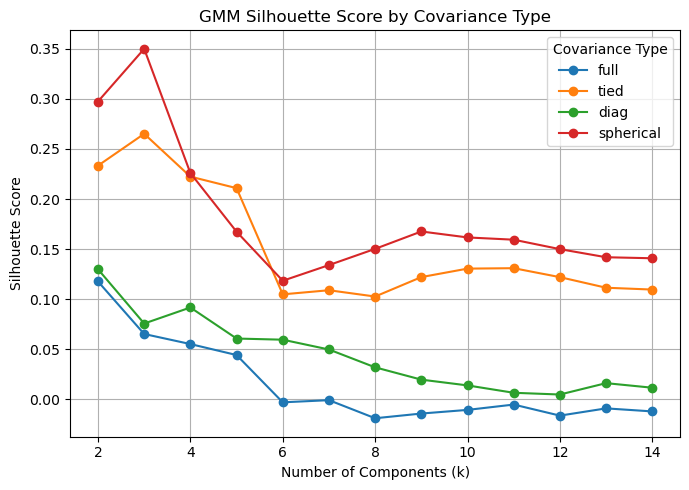

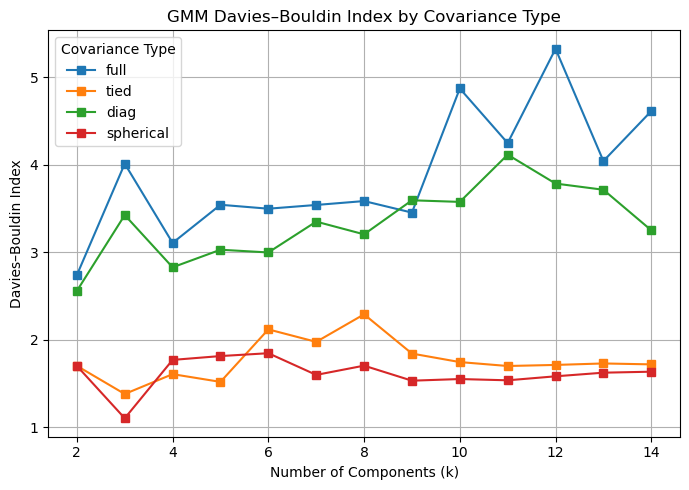

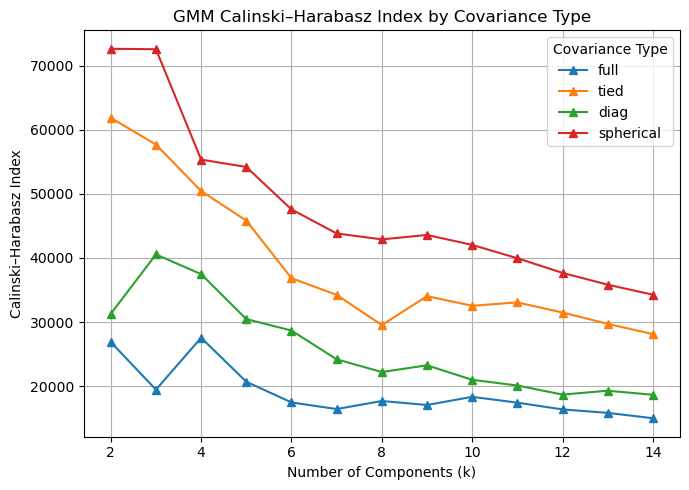

In [23]:
# Plot Silhouette Score
plt.figure(figsize=(7, 5))
for cov in gmm_covariance_types:
    plt.plot(n_components_range, sil_GMM_results[cov], marker='o', label=cov)
plt.title('GMM Silhouette Score by Covariance Type')
plt.xlabel('Number of Components (k)')
plt.ylabel('Silhouette Score')
plt.legend(title='Covariance Type')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Davies-Bouldin Index (lower is better)
plt.figure(figsize=(7, 5))
for cov in gmm_covariance_types:
    plt.plot(n_components_range, dbi_GMM_results[cov], marker='s', label=cov)
plt.title('GMM Davies–Bouldin Index by Covariance Type')
plt.xlabel('Number of Components (k)')
plt.ylabel('Davies–Bouldin Index')
plt.legend(title='Covariance Type')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Calinski–Harabasz Index (higher is better)
plt.figure(figsize=(7, 5))
for cov in gmm_covariance_types:
    plt.plot(n_components_range, chi_GMM_results[cov], marker='^', label=cov)
plt.title('GMM Calinski–Harabasz Index by Covariance Type')
plt.xlabel('Number of Components (k)')
plt.ylabel('Calinski–Harabasz Index')
plt.legend(title='Covariance Type')
plt.grid(True)
plt.tight_layout()
plt.show()

In [31]:
gmm_results = []

for cov_type in gmm_covariance_types:
    print(f"\nRunning GMM with covariance_type = '{cov_type}'")
    start_time = time.time()
    
    gmm = GaussianMixture(n_components=3, covariance_type=cov_type, random_state=42)
    gmm_labels = gmm.fit_predict(X_scaled)
    
    elapsed = time.time() - start_time
    
    # Compute metrics
    sil = silhouette_score(X_scaled, gmm_labels)
    dbi = davies_bouldin_score(X_scaled, gmm_labels)
    chi = calinski_harabasz_score(X_scaled, gmm_labels)
    
    # Store results
    gmm_results.append({
        "Covariance_Type": cov_type,
        "Silhouette": sil,
        "DBI": dbi,
        "CHI": chi,
        "Time_sec": elapsed
    })
    
    # Print results
    print(f"Time taken: {elapsed:.2f} sec")
    print(f"Silhouette Score: {sil:.4f}")
    print(f"Davies–Bouldin Index: {dbi:.4f}")
    print(f"Calinski–Harabasz Index: {chi:.2f}")


Running GMM with covariance_type = 'full'
Time taken: 9.95 sec
Silhouette Score: 0.0653
Davies–Bouldin Index: 4.0131
Calinski–Harabasz Index: 19449.37

Running GMM with covariance_type = 'tied'
Time taken: 5.07 sec
Silhouette Score: 0.2652
Davies–Bouldin Index: 1.3827
Calinski–Harabasz Index: 57681.79

Running GMM with covariance_type = 'diag'
Time taken: 3.53 sec
Silhouette Score: 0.0758
Davies–Bouldin Index: 3.4264
Calinski–Harabasz Index: 40543.14

Running GMM with covariance_type = 'spherical'
Time taken: 1.23 sec
Silhouette Score: 0.3500
Davies–Bouldin Index: 1.1054
Calinski–Harabasz Index: 72551.53


In [32]:
gmm_clean_results = []

for cov_type in gmm_covariance_types:
    print(f"\nRunning GMM with covariance_type = '{cov_type}'")
    start_time = time.time()
    
    gmm = GaussianMixture(n_components=3, covariance_type=cov_type, random_state=42)
    gmm_labels = gmm.fit_predict(X_scaled_clean)
    
    elapsed = time.time() - start_time
    
    # Compute metrics
    sil = silhouette_score(X_scaled_clean, gmm_labels)
    dbi = davies_bouldin_score(X_scaled_clean, gmm_labels)
    chi = calinski_harabasz_score(X_scaled_clean, gmm_labels)
    
    # Store results
    gmm_results.append({
        "Covariance_Type": cov_type,
        "Silhouette": sil,
        "DBI": dbi,
        "CHI": chi,
        "Time_sec": elapsed
    })
    
    # Print results
    print(f"Time taken: {elapsed:.2f} sec")
    print(f"Silhouette Score: {sil:.4f}")
    print(f"Davies–Bouldin Index: {dbi:.4f}")
    print(f"Calinski–Harabasz Index: {chi:.2f}")


Running GMM with covariance_type = 'full'
Time taken: 5.70 sec
Silhouette Score: -0.0018
Davies–Bouldin Index: 5.5725
Calinski–Harabasz Index: 3512.38

Running GMM with covariance_type = 'tied'
Time taken: 1.82 sec
Silhouette Score: 0.1966
Davies–Bouldin Index: 1.6822
Calinski–Harabasz Index: 19407.00

Running GMM with covariance_type = 'diag'
Time taken: 3.20 sec
Silhouette Score: 0.0631
Davies–Bouldin Index: 3.6690
Calinski–Harabasz Index: 9068.41

Running GMM with covariance_type = 'spherical'
Time taken: 1.08 sec
Silhouette Score: 0.2260
Davies–Bouldin Index: 1.5005
Calinski–Harabasz Index: 23051.80


In [20]:
X_sample = resample(X_scaled, n_samples=5000, random_state=42)

cov_types = ['full', 'tied', 'diag', 'spherical']
k_values = range(2, 12)  

# Store results
results = []

for cov in cov_types:
    for k in k_values:
        try:
            gmm = GaussianMixture(n_components=k, covariance_type=cov, random_state=42)
            labels = gmm.fit_predict(X_sample)
            sil = silhouette_score(X_sample, labels)
            print(f"Cov: {cov:9} | k = {k:2} | Silhouette = {sil:.3f}")
            results.append({'Covariance': cov, 'k': k, 'Silhouette': sil})
        except Exception as e:
            print(f"Cov: {cov:9} | k = {k:2} | FAILED: {e}")
            results.append({'Covariance': cov, 'k': k, 'Silhouette': None})

Cov: full      | k =  2 | Silhouette = 0.356
Cov: full      | k =  3 | Silhouette = 0.051
Cov: full      | k =  4 | Silhouette = 0.059
Cov: full      | k =  5 | Silhouette = 0.018
Cov: full      | k =  6 | Silhouette = 0.039
Cov: full      | k =  7 | Silhouette = 0.041
Cov: full      | k =  8 | Silhouette = 0.026
Cov: full      | k =  9 | Silhouette = 0.029
Cov: full      | k = 10 | Silhouette = 0.019
Cov: full      | k = 11 | Silhouette = 0.022
Cov: tied      | k =  2 | Silhouette = 0.253
Cov: tied      | k =  3 | Silhouette = 0.362
Cov: tied      | k =  4 | Silhouette = 0.227
Cov: tied      | k =  5 | Silhouette = 0.071
Cov: tied      | k =  6 | Silhouette = 0.157
Cov: tied      | k =  7 | Silhouette = 0.165
Cov: tied      | k =  8 | Silhouette = 0.122
Cov: tied      | k =  9 | Silhouette = 0.156
Cov: tied      | k = 10 | Silhouette = 0.138
Cov: tied      | k = 11 | Silhouette = 0.133
Cov: diag      | k =  2 | Silhouette = 0.318
Cov: diag      | k =  3 | Silhouette = 0.072
Cov: diag 

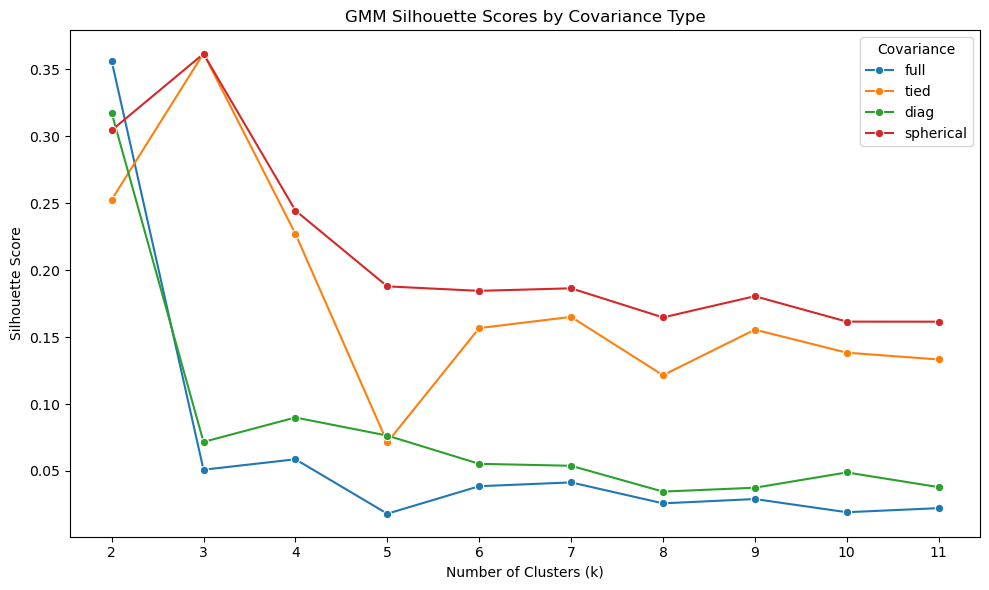

In [26]:
GMM_results = pd.DataFrame(results)

# Plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=GMM_results, x='k', y='Silhouette', hue='Covariance', marker='o')
plt.title("GMM Silhouette Scores by Covariance Type")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.xticks(range(2, 12))
plt.tight_layout()
plt.show()

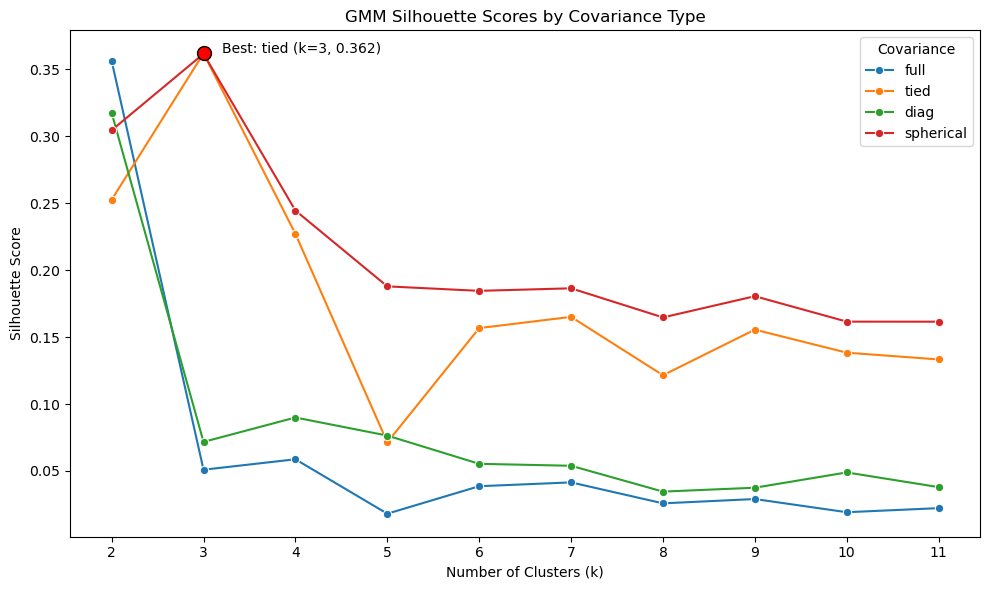


Top 3 GMM settings by Silhouette Score:
   Covariance  k  Silhouette
11       tied  3    0.361909
31  spherical  3    0.361576
0        full  2    0.356310


In [30]:
# Find the best score
best_row = GMM_results.loc[GMM_results['Silhouette'].idxmax()]

# Plot the silhouette scores
plt.figure(figsize=(10, 6))
sns.lineplot(data=GMM_results, x='k', y='Silhouette', hue='Covariance', marker='o')

# Highlight the best point
plt.scatter(best_row['k'], best_row['Silhouette'],
            color='red', s=100, edgecolor='black', zorder=5)
plt.text(best_row['k'] + 0.2, best_row['Silhouette'],
         f"Best: {best_row['Covariance']} (k={best_row['k']}, {best_row['Silhouette']:.3f})",
         fontsize=10, color='black')

plt.title("GMM Silhouette Scores by Covariance Type")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.xticks(range(2, 12))
plt.tight_layout()
plt.show()

# Show top 3 results
print("\nTop 3 GMM settings by Silhouette Score:")
print(GMM_results.nlargest(3, 'Silhouette'))

In [18]:
# Prepare datasets
X_full = X_scaled
X_clean = X_scaled_clean
X_pca_2 = PCA(n_components=2, random_state=42).fit_transform(X_scaled)
X_pca_3 = PCA(n_components=3, random_state=42).fit_transform(X_scaled)

In [19]:
scores = []

for k in range(2, 11):
    gmm = GaussianMixture(n_components=k, covariance_type='tied', random_state=42)
    labels = gmm.fit_predict(X_full)
    score = silhouette_score(X_full, labels)
    print(f"k = {k}, Silhouette Score = {score:.3f}")
    scores.append(score)

k = 2, Silhouette Score = 0.233
k = 3, Silhouette Score = 0.265
k = 4, Silhouette Score = 0.222
k = 5, Silhouette Score = 0.211
k = 6, Silhouette Score = 0.105
k = 7, Silhouette Score = 0.109
k = 8, Silhouette Score = 0.103
k = 9, Silhouette Score = 0.122
k = 10, Silhouette Score = 0.131


In [21]:
clean_scores = []

for k in range(2, 11):
    gmm = GaussianMixture(n_components=k, covariance_type='tied', random_state=42)
    labels = gmm.fit_predict(X_clean)
    score = silhouette_score(X_clean, labels)
    print(f"k = {k}, Silhouette Score = {score:.3f}")
    clean_scores.append(score)

k = 2, Silhouette Score = 0.186
k = 3, Silhouette Score = 0.197
k = 4, Silhouette Score = 0.119
k = 5, Silhouette Score = 0.150
k = 6, Silhouette Score = 0.120
k = 7, Silhouette Score = 0.116
k = 8, Silhouette Score = 0.107
k = 9, Silhouette Score = 0.099
k = 10, Silhouette Score = 0.100


In [22]:
pca2_scores = []

for k in range(2, 11):
    gmm = GaussianMixture(n_components=k, covariance_type='tied', random_state=42)
    labels = gmm.fit_predict(X_pca_2)
    score = silhouette_score(X_pca_2, labels)
    print(f"k = {k}, Silhouette Score = {score:.3f}")
    pca2_scores.append(score)

k = 2, Silhouette Score = 0.556
k = 3, Silhouette Score = 0.610
k = 4, Silhouette Score = 0.478
k = 5, Silhouette Score = 0.444
k = 6, Silhouette Score = 0.401
k = 7, Silhouette Score = 0.394
k = 8, Silhouette Score = 0.364
k = 9, Silhouette Score = 0.357
k = 10, Silhouette Score = 0.361


In [23]:
pca3_scores = []

for k in range(2, 11):
    gmm = GaussianMixture(n_components=k, covariance_type='tied', random_state=42)
    labels = gmm.fit_predict(X_pca_3)
    score = silhouette_score(X_pca_3, labels)
    print(f"k = {k}, Silhouette Score = {score:.3f}")
    pca3_scores.append(score)

k = 2, Silhouette Score = 0.469
k = 3, Silhouette Score = 0.515
k = 4, Silhouette Score = 0.327
k = 5, Silhouette Score = 0.322
k = 6, Silhouette Score = 0.275
k = 7, Silhouette Score = 0.285
k = 8, Silhouette Score = 0.269
k = 9, Silhouette Score = 0.249
k = 10, Silhouette Score = 0.239


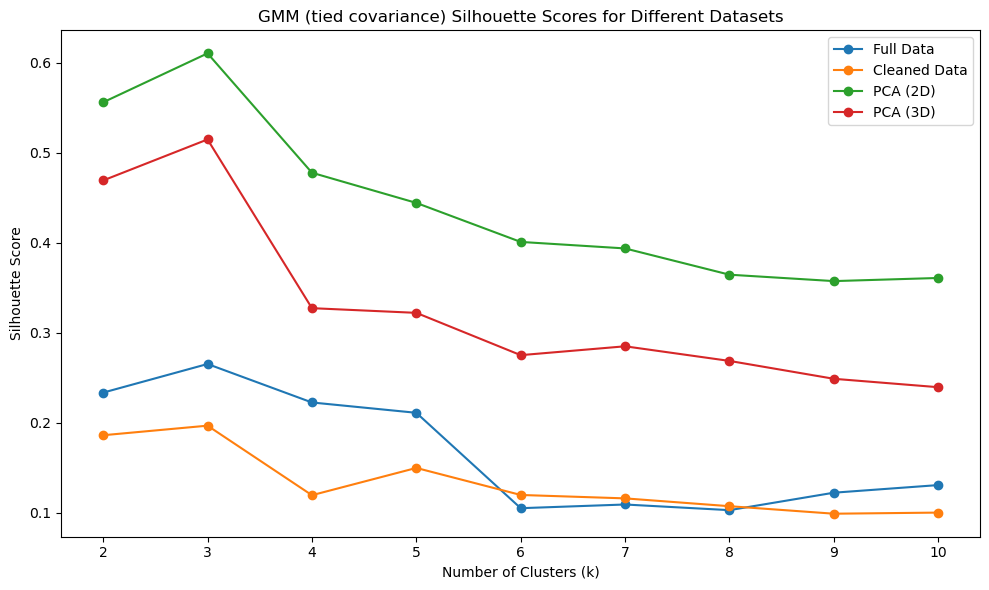

In [29]:
k_values = range(2, 11)  
plt.figure(figsize=(10, 6))

plt.plot(k_values, scores, marker='o', label="Full Data")
plt.plot(k_values, clean_scores, marker='o', label="Cleaned Data")
plt.plot(k_values, pca2_scores, marker='o', label="PCA (2D)")
plt.plot(k_values, pca3_scores, marker='o', label="PCA (3D)")

plt.title("GMM (tied covariance) Silhouette Scores for Different Datasets")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.xticks(k_values)
plt.legend()
plt.tight_layout()
plt.show()

In [31]:
k_values = range(2, 11)

def compute_all_scores_GMM(X):
    sil_scores = []
    dbi_scores = []
    chi_scores = []
    for k in k_values:
        gmm = GaussianMixture(n_components=k, covariance_type='tied', random_state=42)
        labels = gmm.fit_predict(X)
        
        sil = silhouette_score(X, labels)
        dbi = davies_bouldin_score(X, labels)
        chi = calinski_harabasz_score(X, labels)
        
        sil_scores.append(sil)
        dbi_scores.append(dbi)
        chi_scores.append(chi)
        
        print(f"GMM | k={k} | Silhouette={sil:.3f} | DBI={dbi:.3f} | CHI={chi:.3f}")
    
    return sil_scores, dbi_scores, chi_scores

In [32]:
sil_GMM_full, dbi_GMM_full, chi_GMM_full = compute_all_scores_GMM(X_full)
sil_GMM_clean, dbi_GMM_clean, chi_GMM_clean = compute_all_scores_GMM(X_clean)
sil_GMM_pca2, dbi_GMM_pca2, chi_GMM_pca2 = compute_all_scores_GMM(X_pca_2)
sil_GMM_pca3, dbi_GMM_pca3, chi_GMM_pca3 = compute_all_scores_GMM(X_pca_3)

GMM | k=2 | Silhouette=0.233 | DBI=1.704 | CHI=61857.186
GMM | k=3 | Silhouette=0.265 | DBI=1.383 | CHI=57681.786
GMM | k=4 | Silhouette=0.222 | DBI=1.609 | CHI=50439.120
GMM | k=5 | Silhouette=0.211 | DBI=1.521 | CHI=45818.035
GMM | k=6 | Silhouette=0.105 | DBI=2.121 | CHI=36839.117
GMM | k=7 | Silhouette=0.109 | DBI=1.978 | CHI=34235.341
GMM | k=8 | Silhouette=0.103 | DBI=2.293 | CHI=29524.422
GMM | k=9 | Silhouette=0.122 | DBI=1.844 | CHI=34033.908
GMM | k=10 | Silhouette=0.131 | DBI=1.747 | CHI=32533.130
GMM | k=2 | Silhouette=0.186 | DBI=1.980 | CHI=23791.135
GMM | k=3 | Silhouette=0.197 | DBI=1.682 | CHI=19406.997
GMM | k=4 | Silhouette=0.119 | DBI=2.034 | CHI=18618.343
GMM | k=5 | Silhouette=0.150 | DBI=1.798 | CHI=17703.734
GMM | k=6 | Silhouette=0.120 | DBI=1.869 | CHI=17084.376
GMM | k=7 | Silhouette=0.116 | DBI=1.889 | CHI=15791.993
GMM | k=8 | Silhouette=0.107 | DBI=1.782 | CHI=14775.520
GMM | k=9 | Silhouette=0.099 | DBI=2.214 | CHI=12918.608
GMM | k=10 | Silhouette=0.100 

In [24]:
# Fit GMM with 3 clusters
gmm = GaussianMixture(n_components=3, covariance_type='tied', random_state=42)
spotify_df['gmm_cluster'] = gmm.fit_predict(X_scaled)


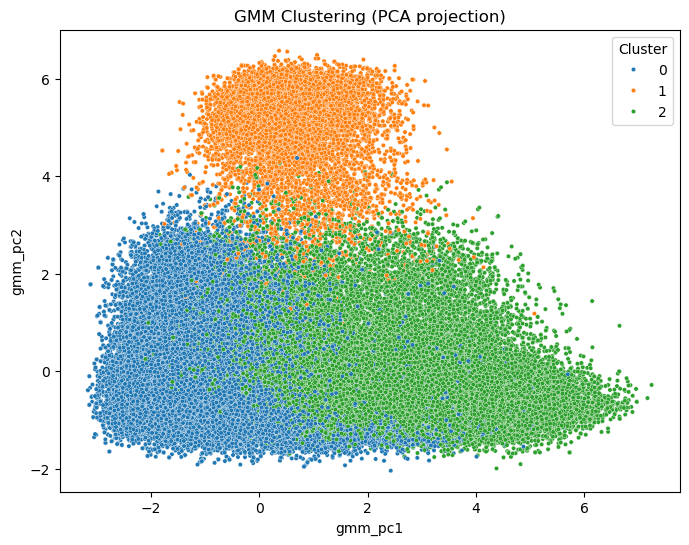

In [25]:
pca = PCA(n_components=2)
pc_gmm = pca.fit_transform(X_scaled)
spotify_df['gmm_pc1'], spotify_df['gmm_pc2'] = pc_gmm[:, 0], pc_gmm[:, 1]

plt.figure(figsize=(8,6))
sns.scatterplot(x='gmm_pc1', y='gmm_pc2', hue='gmm_cluster', palette='tab10', data=spotify_df, s=10)
plt.title('GMM Clustering (PCA projection)')
plt.legend(title='Cluster')
plt.show()

In [ ]:
X_sample, labels_sample = resample(X_scaled, spotify_df['gmm_cluster'], n_samples=10000, random_state=42)
sil = silhouette_score(X_sample, labels_sample)
print(f"Silhouette Score (GMM): {sil:.3f}")